In [1]:
import matplotlib.pyplot as plt  
%matplotlib inline 

import matplotlib.pylab as pylab
# larger images in plot
pylab.rcParams['figure.figsize'] = 24, 24

import numpy as np
import cv2 # OpenCV biblioteka

# needed for line_thickness and space_height calculations
from collections import Counter

def show_in_window_and_below(img, below=True):
    if (below):
        plt.imshow(img, 'gray')
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

#### Please set the path to image that will be parsed (type ' ./ ' and press TAB for help)

In [2]:
IMAGE_PATH = './images/dataset/LJeto.jpg'

## Select 'Run all cells' from Cell Menu
<br>
<br>

### Constants

Image paths constants

In [3]:
DEFAULT_IMAGE_PATH = './images/dataset/bolujem.jpg'
# folder path will not end with a slash
TEMPLATES_PATH = './images/templates'
RESULTS_PATH = './results'

Pixels constants

In [4]:
BLACK = 0 # black pixel's color
WHITE = 255 # white pixel's color

Notes constants

In [5]:
# We currently support notes
# from: above 2nd UPPER ledger/helper line
# to:   below 2nd LOWER ledger/helper line
clefs = {
  'treble': ['D6','C6',  'B5','A5','G5','F5','E5','D5','C5',  'B4','A4','G4','F4','E4','D4','C4',  'B3','A3','G3'],
  'bass': ['F4','E4','D4','C4',  'B3','A3','G3','F3','E3','D3','C3',  'B2','A2','G2','F2','E2','D2','C2',  'B1']
}

# some of the "important" element codes
HIGHEST_SPACING = 0 #   highest ledger/helper spacing
FIRST_LINE = 5      # first full-width staff-line
FIFTH_LINE = 13     # last full-width staff-line
LOWEST_SPACING = 18 #   lowest ledger/helper spacing

In [6]:
# runs calculations
def calculate_runs(img):
    runs = [[1] for x in xrange(img.shape[1])] # each column starts with 1 black pixel
    black_runs_flat, white_runs_flat = [], []
    for col in xrange(img.shape[1]): # iterate through all columns
        img[0,col] = 0 # PAINT THE FIRST PIXEL IN PREDEFINED COLOR, to make all columns start the same
        run_index = 0 # start the run
        for row in xrange(1, img.shape[0]): # for each pixel/row in current column
            if (img[row-1 ,col] != img[row, col]):  # if they are not the same,
                # memorize the old run in corresponding array
                if (run_index % 2 == 0): # black run
                    black_runs_flat.append(runs[col][run_index])
                else:
                    white_runs_flat.append(runs[col][run_index])
                # start a new run
                run_index += 1
                runs[col].append(0)
            runs[col][run_index] += 1     # add a pixel to the current run
        # the column ended ==> save the last run for the ended column
        if (run_index % 2 == 0): # black run
            black_runs_flat.append(runs[col][run_index])
        else:
            white_runs_flat.append(runs[col][run_index])
    return runs, black_runs_flat, white_runs_flat

### Line *thickness* and *spacings* (black and white runs) analysis

In [7]:
def calculate_line_thickness(black_flat):
    num_top = 4 # number of top/most common runs
    black_count = Counter(black_flat) # Counter({1: 3, 8: 1, 3: 1, ...})
    m_c_black = black_count.most_common(num_top)
    print 'Top', num_top, 'most_common_black_runs:', m_c_black
    
    m_c_black1 = m_c_black[0][0]
    if (len(m_c_black) >= 2):
        m_c_black2 = m_c_black[1][0]
        if (m_c_black1*3 < m_c_black2): # kind of a sanity check
            line_thickness = m_c_black1
        else:
            line_thickness = (m_c_black1 + m_c_black2) / 2.
    else:
        line_thickness = m_c_black1
    
    print '>>> Calculated line thickness:  ', line_thickness
    return line_thickness

def calculate_line_spacing(white_flat, image_height):
    num_top = 4 # number of top/most common runs
    white_count = Counter(white_flat) # print white_count.most_common(50)
    m_c_white = white_count.most_common(num_top)
    print 'Top', num_top, 'most common white runs', m_c_white
    
    m_c_white1 = m_c_white[0][0]
    if (len(m_c_white) >= 2):
        m_c_white2 = m_c_white[1][0]
        
        if (m_c_white1 > image_height*0.5): # sanity check
            line_spacing = m_c_white2
        else:
            if (m_c_white2 > image_height*0.5):
                line_spacing = m_c_white1
            else:
                line_spacing = (m_c_white1 + m_c_white2) / 2.
    else:
        line_spacing = m_c_white[0][0]
    print '>>> Calculated line spacing: ', line_spacing
    return line_spacing

In [8]:
def remove_staff_lines(img, runs, line_height, staff_thickness_multiplier):
    # copy the image.. python is pass-by-object-reference so it is necessary!
    p = img.copy() # pass-by-object-reference: https://stackoverflow.com/a/33066581/2101117
    # NOTE: copying is NOT NECESSARY if we won't use the passed `img` after this function returns
    #edit the image
    for c in xrange(len(runs)):        # for every column
        cumulative = 0 # initialize the number of passed pixels
        for r in xrange(len(runs[c])): # for every run
            run_length = runs[c][r]
            if (r % 2 == 0): # black runs # every black run longer than 2 * line_height is deleted/whitened
                if (run_length < line_height * staff_thickness_multiplier):
                    # ++ AKO JE SLJEDEĆI/PRETHODNI %% BIJELI %% RUN = VISINA PRAZNINE +-1
                    # ++ AKO JE SLJEDEĆI/PRETHODNI %%  CRNI  %% RUN = VISINA LINIJE +-1
                    p[cumulative:cumulative + run_length, c] = [255]*(run_length)
            #else: # white runs
            #    do something maybe ?
            cumulative += run_length
    return p

In [9]:
def remove_staff_lines_with_lines_only(img, runs, line_height, staff_thickness_multiplier, lines_only_img):
    # copy the image.. python is pass-by-object-reference so it is necessary!
    p = img.copy() # pass-by-object-reference: https://stackoverflow.com/a/33066581/2101117
    # NOTE: copying is NOT NECESSARY if we won't use the passed `img` after this function returns
    #edit the image
    for c in xrange(len(runs)):        # for every column
        cumulative = 0 # initialize the number of passed pixels
        for r in xrange(len(runs[c])): # for every run
            run_length = runs[c][r]
            if (r % 2 == 0): # black runs # every black run longer than 2 * line_height is erased
                if (run_length < line_height * staff_thickness_multiplier):
                    for compare_px in xrange(cumulative, cumulative + run_length):
                        if (lines_only_img[compare_px, c] == BLACK):
                            p[compare_px, c] = 255
                        # p[cumulative:cumulative + run_length, c] = [255]*(run_length)
            cumulative += run_length
    return p

< # # # #  # # # #  # # # #  # # # #  # # # #  # # # >
### (RLE) run-based approach to  LOCATING  STAVES
< # # # #  # # # #  # # # #  # # # #  # # # #  # # # >

In [10]:
# FOR ONE STAVE -- Y_location
def print_staff_locations_y(staff_locations):
    staves_keylist = staff_locations.keys()
    staves_keylist.sort()
    print '\nSORT %d staves and their lines by y-coordinates' % (len(staff_locations))
    # print staff_locations
    for staves_key in staves_keylist:
        print "  STAVE AT Y = %s" % (staves_key)
        staff = staff_locations[staves_key][1]
        staff_keylist = staff.keys()
        staff_keylist.sort()
        for staff_key in staff_keylist:
            print '\tstaff element %s: %s' % (staff_key, staff[staff_key])
        print ''

# FOR MULTIPLE STAVES --- X_locations
def print_staff_locations_x(staff_locations_x):
    print 'staff_locations', staff_locations_x
    if staff_locations_x == {}:
        print 'Staff locations are EMPTY! :O'
        return -1
    
    staff_locations_x_keys = staff_locations_x.keys()
    staff_locations_x_keys.sort()
    print '\n----\nSORT %d staff location dictionaries' % (len(staff_locations_x))
    for staff_loc_x_key in staff_locations_x_keys:
        print '----\nStaves for x =', staff_loc_x_key
        staff_locations = staff_locations_x[staff_loc_x_key]
        print_staff_locations_y(staff_locations)
    return 0

# Adds "help" lines and spaces (eng. "ledger lines/spaces") to `locaions` dictionary
def add_helper_spaces_and_lines(locations, line_thickness, line_spacing, cumulative):
    line_thickness = int(round(line_thickness)) # round(2.4) = 2 ||| round(2.6) = 3  :)
    line_spacing = int(round(line_spacing))
    
    help_space_3_up_y = cumulative - (2 * line_thickness) - (3 * line_spacing) 
    locations[help_space_3_up_y] = (0, line_spacing)
    help_line_2_up_y = cumulative - (2 * line_thickness) - (2 * line_spacing)
    locations[help_line_2_up_y] = (1, line_thickness)
    help_space_2_up_y = cumulative - (1 * line_thickness) - (2 * line_spacing)
    locations[help_space_2_up_y] = (2, line_spacing)
    help_line_1_up_y = cumulative - (1 * line_thickness) - (1 * line_spacing)
    locations[help_line_1_up_y] = (3, line_thickness)
    help_space_1_up_y = cumulative - (0 * line_thickness) - (1 * line_spacing)
    locations[help_space_1_up_y] = (4, line_spacing)
    
    lowest_line = max(locations.keys()) # MAX because the lower the LINE, the bigger the Y-coordinate
    lowest_line_end = lowest_line + locations[lowest_line][1]
    
    help_space_1_down_y = lowest_line_end + (0 * line_thickness) + (0 * line_spacing)
    locations[help_space_1_down_y] = (14, line_spacing)
    help_line_1_down_y = lowest_line_end + (0 * line_thickness) + (1 * line_spacing)
    locations[help_line_1_down_y] = (15, line_thickness)
    help_space_2_down_y = lowest_line_end + (1 * line_thickness) + (1 * line_spacing)
    locations[help_space_2_down_y] = (16, line_spacing)
    help_line_2_down_y = lowest_line_end + (1 * line_thickness) + (2 * line_spacing)
    locations[help_line_2_down_y] = (17, line_thickness)
    help_space_3_down_y = lowest_line_end + (2 * line_thickness) + (2 * line_spacing) 
    locations[help_space_3_down_y] = (18, line_spacing)
    return 0 # everything is OK

def run_is_spacing_candidate(run_length, line_spacing):
    return (line_spacing * 0.85 <= run_length <= line_spacing * 1.15)

def run_is_line_candidate(run_length, line_thickness):
#     lower_bound = line_thickness * 0.4 if line_thickness > 3.6 else 1 # Helps with thin average lines
    return (line_thickness * 0.4 <= run_length <= line_thickness * 1.6)
    
# Checks if there is a staff and returns a tuple (found, start_pixel, locations, end_pixel)
#   1.1) True,  or  False
#   1.2) The y-coordinate of the stave's START (start_pixel),  or  -1
#   1.3) Dictionary of pairs: (line_or_space_start_y, (line_space_CODE, line_thickness))
#   1.4) The y-coordinate of the stave's END (end_pixel),  or  -1
def get_staff_with_spaces(run_index, runs, image_column, cumulative, line_thickness, line_spacing):
    # initialize the return dictionary with a line number 1, which has the CODE=5. Why 5? See the next line
    # >> help_space3_up (CODE=0), help_line2_up, help_space2_up, help_line1_up, help_space1_up, FIRST_LINE
    locations = {cumulative: (5, runs[run_index])} # first line starts at the current index
    line_space_counter = 6 # first line is saved, now go for other SPACES AND LINES
    # cumulative -> how low (Y) are we in this image column - Make_first_row_black_in_runs_calc idea will be discarded!
    end_pixel = cumulative + runs[run_index] # determines the y-coordinate where this the last-found element end
    stave_found = True
    
    for i in range(1, 9):
        run_length = runs[run_index + i]
        if i%2 == 1: # i is odd for line_spacings, since for i=0 we get first LINE's index (run_index)
            if not run_is_spacing_candidate(run_length, line_spacing):
                stave_found = False
                break
        else: # i%2 == 0
            if not run_is_line_candidate(run_length, line_thickness):
                stave_found = False
                break
        # we came to execute this line, so this run (space/line) is ok
        locations[end_pixel] = (line_space_counter, run_length) # add the SPACE/LINE
        line_space_counter += 1 # look for the next SPACES AND LINES
        end_pixel += run_length # advance down the column
    
    if not stave_found:
        return False, -1, {}, -1 # not_found, no_start, no_locations, no_end
    
    # prepare the return values
    add_helper_spaces_and_lines(locations, line_thickness, line_spacing, cumulative)
    start_pixel = min(locations.keys())
    # get the last line's y_coordinate and add her height to it -- that's where this stave ends
    lowest_space = max(locations.keys()) # MAX because the lower the SPACE, the bigger the Y-coordinate
    end_pixel = lowest_space + locations[lowest_space][1] # lowest SPACE at `lowest_space`, height: locations[lowest_space][1]
    return True, start_pixel, locations, end_pixel

# IS beginning of the first stave close to the beginning of the second?
def staves_are_close(stave1, stave2, line_thickness):
    return abs(stave1[1][0] - stave2[1][0]) < line_thickness

def find_staves_in_runs(runs, image_column, line_thickness, line_spacing):
    run_index = 0 # current run index
    cumulative = 0 # how many pixels did we pass - for getting run's color# The paint_the_first_row_black idea will be discarded!!!
    
    staff_counter = 0
    staves = {}
    while (run_index < len(runs)):# WHILE, because we need more control over the index vlue
        run_length = runs[run_index]
        if (image_column[cumulative] == BLACK and run_is_line_candidate(run_length, line_thickness)):
            staff_is_found, start_pixel, staff, end_pixel = get_staff_with_spaces(run_index, runs, image_column, cumulative, line_thickness, line_spacing)
            if (staff_is_found): # YEA!
                staff_counter += 1
                staves[start_pixel] = (staff_counter, staff, end_pixel)
                # A staff was found, so we need to go down 8 runs (4*spacing, 4*line) until the last line of this staff
                for r_i in range(run_index, run_index+9): # OR 8??
                    cumulative += runs[r_i] # print 'adding', runs[r_i], 'to cumulative'
                run_index += 8
            else: # staff was NOT found
                cumulative += run_length
        else:
            cumulative += run_length
        run_index += 1
    
    return len(staves), staves # return the size and the staves dictionary

# check that NO staves from the `staves` dictionary are close to this `stave`
def no_staves_are_close(staves, stave, staff_start):
    close_range = (stave[2] - staff_start)/2
    starts_list = range(staff_start - close_range, staff_start + close_range + 1) # + 1 because range() doesn't include the last element
    starts_list.remove(staff_start)
    intersection = [start for start in starts_list if start in staves]
    return intersection == []

### Check that staffs for each key (X coordinate) are counted well -- in the following code cell
     sheet music
    '''''''''''''
    |   TITLE   | If each dash (-) is one X value, then the
    | --------- | first 4 Xes will have 2 staves, and the 
    | ----      | remaining 5 will have only one.
    |___________| NOTE: staff numbers in dictionary tuples START FROM 1

In [11]:
def any_keys_close_to(possibly_missing_key, smaller_dict, threshold=40):
    for key in smaller_dict:
        diff = abs(key - possibly_missing_key)
        if (diff <= threshold): # there IS a key close to the possibly_missing_key
            return True
    # We came here, so no keys close to the possibly_missing_key!
    return False

def get_keys_not_in_second_dict(bigger_dict, smaller_dict):
    missing_keys = []
    for possibly_missing_key in bigger_dict:
        if not(any_keys_close_to(possibly_missing_key, smaller_dict)):
            missing_keys.append(possibly_missing_key)
            print 'FOUND MISSING KEY', possibly_missing_key
    return missing_keys

def copy_staff_from_a_valid_dictionary(valid_x_staves_loc, invalid_x_staves_loc, printing_on=False):
    if (printing_on):
        print '\t:::::;;; PRINTING VALID AND INVALID STAVES_LOC DICTIONARIES ;;:::::::'
        print '\n ===== VALID ===='
        print_staff_locations_y(valid_x_staves_loc)
        print '\n ===== INVALID ===='
        print_staff_locations_y(invalid_x_staves_loc)
    
    # get the keys and sort them
    sorted_VALID_dict_keys = valid_x_staves_loc.keys()
    sorted_VALID_dict_keys.sort()
    
    sorted_INVALID_dict_keys = invalid_x_staves_loc.keys()
    sorted_INVALID_dict_keys.sort()
    
    
    # memorize their lenghts
    valid_keys_length = len(sorted_VALID_dict_keys)
    invalid_keys_length = len(sorted_INVALID_dict_keys)
    
    difference_in_key_lenght = valid_keys_length - invalid_keys_length
    if (difference_in_key_lenght > 0): # Invalid dictionary is missing some staves - more common case
        keys_not_present_in_invalid_dict = get_keys_not_in_second_dict(sorted_VALID_dict_keys, sorted_INVALID_dict_keys)
        print 'keys that INVALID dict is missing:', keys_not_present_in_invalid_dict
        for valid_missing_keys in keys_not_present_in_invalid_dict:
            invalid_x_staves_loc[valid_missing_keys] = valid_x_staves_loc[valid_missing_keys]
    else: # invalid dict has more "staves" ---- just delete the invalid values :D
        invalid_staffs_keys = []
        # SLICE IT!!!
        keys_not_present_in_valid_dict = get_keys_not_in_second_dict(sorted_INVALID_dict_keys, sorted_VALID_dict_keys)
        print 'keys that VALID dict is missing:', keys_not_present_in_valid_dict
        for invalid_key in keys_not_present_in_valid_dict:
            print 'deleting key', loc_key, '.. use my_dict.pop(key, None) to get and delete it'
            del invalid_x_staves_loc[invalid_key]
    
    # we need to sort the keys again, since their number changed
    sorted_INVALID_dict_keys = invalid_x_staves_loc.keys()
    sorted_INVALID_dict_keys.sort()
    
    print 'adjusting fixed dictionary\'s staff numbers...'
    staff_counter = 1 # staff numbers start from ONE
    for staff_key in sorted_INVALID_dict_keys:
        print 'Staff at y = %d had the number %d' % (staff_key, invalid_x_staves_loc[staff_key][0])
        # staves[start_pixel] = (staff_counter, staff, end_pixel)
        invalid_x_staves_loc[staff_key] = (staff_counter, invalid_x_staves_loc[staff_key][1], invalid_x_staves_loc[staff_key][2])
        print 'Now, the number is %d' % (invalid_x_staves_loc[staff_key][0])
        staff_counter += 1
    print '\t <<<< FIXING DONE! >>> '
    if (printing_on):
        print '\t:::::;;; PRINTING VALID AND INVALID STAVES_LOC DICTIONARIES ;;:::::::'
        print '\n ===== VALID ===='
        print_staff_locations_y(valid_x_staves_loc)
        print '\n ===== INVALID - NOW ALSO VALID ===='
        print_staff_locations_y(invalid_x_staves_loc)
    return 0

def get_invalid_x_stave_locations(x_stave_locations):
    print '\n~ ~ ~ ~ ~ ~\n  validating x_stave_locations....'
    invalid_x_stave_locations = [] # not used...
    sorted_x_staves_keys = x_stave_locations.keys()
    sorted_x_staves_keys.sort()
    lengths = [len(x_stave_locations[x_staves_key]) for x_staves_key in sorted_x_staves_keys]
    
    # initialize the currently valid length to the maximum length
    max_length = max(lengths)
    valid_lenght = max_length
    print 'lengths: ', lengths, '| max:', valid_lenght
    
    index_of_key = 0
    for x_staves_key in sorted_x_staves_keys:
        current_x_staves_loc = x_stave_locations[x_staves_key]
        current_length = len(current_x_staves_loc)# print 'checking key:', x_staves_key, 'of size', current_length
        
        if (current_length <= valid_lenght): # the number of staves can decrease (or stay the same)
            valid_lenght = current_length
        else: # but if it INCREASES, it's probably an ERROR!
            print ' >> WARNING << number of staves for X = %s is BIGGER than the last one' % x_staves_key
            print ' >> trying to fix it...'
            # determine where is the error
            # We will fix it by copying the missing staves from a neighbour x_stave_location dictionary
            if (index_of_key - 1 > 0):
                one_x_staves_loc_before = x_stave_locations[sorted_x_staves_keys[index_of_key - 1]]
                if (index_of_key + 1 < len(sorted_x_staves_keys)): # one after
                    one_after_or_two_x_staves_loc_before = x_stave_locations[sorted_x_staves_keys[index_of_key + 1]]
                else: # if it's the last dictionary, go two dicts behind
                    if (index_of_key - 2 >= 0):
                        one_after_or_two_x_staves_loc_before = x_stave_locations[sorted_x_staves_keys[index_of_key - 2]]
                    else:
                        print ' >>WARNING<< size is equal to (2?) --->', len(sorted_x_staves_keys)
                        one_after_or_two_x_staves_loc_before = one_x_staves_loc_before # just do something.. :D
                        return []
                
                # if the two nearest neighbours are of even sizes, this dict is invalid!
                if len(one_x_staves_loc_before) == len(one_after_or_two_x_staves_loc_before):
                    print 'error found in this dictionary'
                    valid_x_staves_loc = one_x_staves_loc_before
                    invalid_x_staves_loc = current_x_staves_loc
                else: # We ASSUME that the invalid dictionary was the one BEFORE the current one
                    print 'INVALID is the one before this, with key', sorted_x_staves_keys[index_of_key - 1]
                    valid_x_staves_loc = current_x_staves_loc # We ASSUME that current dict is valid
                    invalid_x_staves_loc = x_stave_locations[sorted_x_staves_keys[index_of_key - 1]]
                # try to fix the problem
                copy_staff_from_a_valid_dictionary(valid_x_staves_loc, invalid_x_staves_loc)
            else: # The first dictionary is invalid :O # WE ASSUME THAT THE SECOND DICT IS VALID !!!
                print ' >> WARNING << first x_stave_location is shorter than the max | ', # comma--print to same line
                print '(%d < %d)' % (len(first_x_stave_location), valid_lenght)
                print 'unahndled case - watch for exceptions and check results! Women and children first! :D'
                return [sorted_x_staves_keys[0]]
        index_of_key += 1 # !!!
    
    return [], max_length # "Everything is OK."

### Main method for locating staves  (it calls find_staves_in_runs (two cells above))

In [12]:
def locate_lines_with_runs(lines_only_img):
    print 'lines_only_img dimensions', lines_only_img.shape
    img_height, img_width = lines_only_img.shape # unpack values
    
    # runs calculation, for thickness and spacing
    runs, black_runs_flat, white_runs_flat = calculate_runs(lines_only_img)
    line_thickness = calculate_line_thickness(black_runs_flat)
    line_spacing = calculate_line_spacing(white_runs_flat, img_height)
    
    # get the columns that we will check for lines  #  IDEA:  Parametrize this! -- described in  IDEJE.txt
    columns_to_check = [img_width/5, img_width/4, img_width/3, img_width/2, img_width/3*2, img_width/4*3]
    print 'columns_to_check', columns_to_check
    
    search_width = 3 # how wide will we look arround each pixel - to BOTH sides!
    resulting_staves = {} # DICTIONARY!
    
    for col_to_check in columns_to_check:
        column_staves = resulting_staves[col_to_check] = {} # shorter name === column_staves
        
        start_column, end_column = col_to_check-search_width, col_to_check+search_width
        column_range = range(start_column, end_column + 1) # + 1 because range() doesn't include the last element
        for col in column_range:
            image_column = lines_only_img[0:img_height, col].tolist() # convert numpy array to python list
            num_of_staves, staves = find_staves_in_runs(runs[col], image_column, line_thickness, line_spacing)
            if (num_of_staves > 0):
                for staff_start in staves: # iterate through keys # or something like that
                    # IF there is NO staffs that are close to this one (on y-axis)
                    if (no_staves_are_close(column_staves, staves[staff_start], staff_start)):
                        column_staves[staff_start] = staves[staff_start]
    
    invalid_x_stave_locations, number_of_staves = get_invalid_x_stave_locations(resulting_staves)
    if (invalid_x_stave_locations == []):
        return resulting_staves, number_of_staves
    return {}

In [13]:
def dilate_and_save(img, kernel_w, kernel_h):
    '''Dilates a binary image with kernel of specified dimensions.
    saves the image to hard drive and returns the saved image'''
    kernel = np.ones((kernel_w, kernel_h), dtype=np.int)
    lines_only_img = cv2.dilate(img, kernel, iterations=1)
    lines_only_img_path = RESULTS_PATH + '/dil_{}_{}.jpg'.format(kernel_w, kernel_h)
    cv2.imwrite(lines_only_img_path, lines_only_img)
    return lines_only_img

def erode_and_save(img, kernel_w_e, kernel_h_e, kernel_w_d=0, kernel_h_d=0):
    '''Erodes a binary image with kernel of specified dimensions.
    saves the image to hard drive and returns the saved image'''
    if (kernel_w_d == 0):
        dil_str = ''
    else:
        dil_str = '_dil_{}_{}'.format(kernel_w_d, kernel_h_d)
    kernel = np.ones((kernel_w_e, kernel_h_e), dtype=np.int)
    lines_only_img = cv2.erode(img, kernel, iterations=1)
    lines_only_img_path = RESULTS_PATH + '/er_{}_{}{}.jpg'.format(kernel_w_e, kernel_h_e, dil_str)
    cv2.imwrite(lines_only_img_path, lines_only_img)
    return lines_only_img

### Two approaches on getting the lines-only image:
####  |__ 1: dilate and then erode with a very wide kernel (written right below this heading)
####  |__ 2: use the previous approach's image + remove all non-staff-line symbols (implementation started in 'testing stuff' notebook)

In [14]:
def get_lines_only_img(img):
    threshold = cv2.ADAPTIVE_THRESH_MEAN_C
    method, block, c = cv2.THRESH_BINARY, 55, 9
    img_ada = cv2.adaptiveThreshold(img, 255, threshold, method, block, c)

    # dilate with 1x50 --> erode with 2x50  | this has the best results
    kernel_w, kernel_h = 1, 50
    dilated = dilate_and_save(img_ada, kernel_w, kernel_h)
    kernel_w_e, kernel_h_e = 2, 50
    return erode_and_save(dilated, kernel_w_e, kernel_h_e, kernel_w, kernel_h)

def get_staves_x_locations(img, print_result=True):
    '''Locate lines on the given image and print results (if print_results is `True`)
    Returns: staff lines LOCATIONS and the maximum number of staves in one image's column.'''
    lines_only_img = get_lines_only_img(img) # get_lines_only_img_CLEAR # approach 2 - maybe in the future
    
    # use the lines-only image to locate the staves
    staff_locations, number_of_staves = locate_lines_with_runs(lines_only_img)
    
    if (print_result):
        print_staff_locations_x(staff_locations)
    print '\n\n==== ==== ====\n Setting X-staves locations and maximum number of staves in a column...\nDone!'
    return staff_locations, number_of_staves, lines_only_img

# = = = = = = = = = = vvv = = = = = = = = = = =
# <<< IMAGE IS BEING LOADED HERE >>>
<h2>Obtain X-staves locations, maximum number of staves and the *lines-only* image</h2>

In [15]:
if (IMAGE_PATH == ''):
    IMAGE_PATH = DEFAULT_IMAGE_PATH
img = cv2.imread(IMAGE_PATH, 0) # 0 --> read as grayscale
staves_x_locations, number_of_staves, lines_only_img = get_staves_x_locations(img, False) # False ---> DON'T PRINT!

lines_only_img dimensions (3264L, 2448L)
Top 4 most_common_black_runs: [(5, 18981), (4, 12513), (1, 2448), (3, 381)]
>>> Calculated line thickness:   4.5
Top 4 most common white runs [(15, 14984), (14, 9247), (283, 965), (282, 821)]
>>> Calculated line spacing:  14.5
columns_to_check [489L, 612L, 816L, 1224L, 1632L, 1836L]

~ ~ ~ ~ ~ ~
  validating x_stave_locations....
lengths:  [3, 3, 3, 3, 3, 3] | max: 3


==== ==== ====
 Setting X-staves locations and maximum number of staves in a column...
Done!


In [16]:
def get_image_name():
    dot_index = IMAGE_PATH.rfind('.')  # last dot's index
    last_slash = IMAGE_PATH.rfind('/') # last slash index
    image_name = IMAGE_PATH[last_slash + 1 : dot_index]
    return image_name

# generates and saves the no-lines image to a file and returns it's name
def gen_and_save_no_lines_image(img, lines_only_img):
    adaptiveMethod, thresholdType, blockSize, C = cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 55, 35

    img_ada = cv2.adaptiveThreshold(img, 255, adaptiveMethod, thresholdType, blockSize, C)

    runs, black_runs_flat, white_runs_flat = calculate_runs(img_ada) # runs calculation, for thickness and spacing
    line_thickness = calculate_line_thickness(black_runs_flat)
    line_spacing = calculate_line_spacing(white_runs_flat, img_ada.shape[0]) # calculation needs image height

    lines_only_img = get_lines_only_img(img) # ...
    erode_width = int(line_thickness + 1)
    lines_only_img = cv2.erode(lines_only_img, np.ones((erode_width, 1), dtype=np.int)) # thickens the lines

    thickness_mul = 1.5 # staff_thickness_multiplier

    # we can send the grayscale image, also :D  Just send `img` instead of `img_ada`
    result = remove_staff_lines_with_lines_only(img_ada, runs, line_thickness, thickness_mul, lines_only_img)
    no_lines_image_path = RESULTS_PATH + '/' + get_image_name() + '_RM_S_L_LINES_ONLY_b{}_c{}_ada{}_er_kw{}.jpg'
    no_lines_image_path = no_lines_image_path.format(blockSize, C, adaptiveMethod, erode_width)
    cv2.imwrite(no_lines_image_path, result)
    
    print 'No-lines image is saved at: ' + no_lines_image_path
    return no_lines_image_path

NO_LINES_IMAGE_PATH = gen_and_save_no_lines_image(img, lines_only_img)

Top 4 most_common_black_runs: [(3, 15754), (4, 13792), (1, 2857), (5, 940)]
>>> Calculated line thickness:   3.5
Top 4 most common white runs [(16, 15180), (15, 6026), (17, 1828), (284, 798)]
>>> Calculated line spacing:  15.5
No-lines image is saved at: ./results/LJeto_RM_S_L_LINES_ONLY_b55_c35_ada0_er_kw4.jpg



<<<<  Pitch recognition  >>>>
---

### In MusicXML, scientific pitch notation is used  (see <a href="https://en.wikipedia.org/wiki/Scientific_pitch_notation"> wikipedia page about Scientific pitch notation</a>)
Therefore, we used it too.

### Obtain the closest / corresponding staff

In [17]:
def get_closest_staff_locations_to_x(staff_locations_by_x, symbol_X_coordinate):
    sorted_loc_by_x_keys = staff_locations_by_x.keys()
    sorted_loc_by_x_keys.sort() # keys are now sorted # BUT NO NEED FOR SORTING IN THIS ALGORITHM !
    
    if (symbol_X_coordinate in sorted_loc_by_x_keys): # in case there is the same key as symbol_X_coordinate
        return symbol_X_coordinate
    
    chosen_key, min_diff = -1, 2000 # get the chosen_key  with  minimal difference from symbol_X_coordinate
    for x_key in sorted_loc_by_x_keys:
        diff = abs(x_key - symbol_X_coordinate)
        if (diff < min_diff):
            min_diff = diff
            chosen_key = x_key
    return staff_locations_by_x[chosen_key]

# get the staff that contains the sent symbol (his y coordinate, actually)
# returns the matched staff and it's key (if return_staff_key is `True`) from staff_locations dictionary
def get_staff(symbol_y_coordinate, staff_locations, return_staff_key=False):
    # get staff locations keys (y-coordinates of staves beginnings)
    sorted_staff_locations_keys = staff_locations.keys()
    sorted_staff_locations_keys.sort() # make them sorted # NOTE :::: sorted_keys.reverse()  REVERSES THE SORT! (returns None!)
    
    # go through sorted keys in dictionary of staves (they are y-coordinates of each staff's beginning)
    # and choose only ones that are above the symbol's y-coordinate (i.e. their y-coordinate is a smaller number)
    candidates = [staff_key for staff_key in sorted_staff_locations_keys if (staff_key <= symbol_y_coordinate)]
    chosen_staff_key = candidates[len(candidates) - 1]
    
    # check that the symbol is valid, i.e. not lower than the chones staff's height
    # (exaple: if staff starts at 500px and ends at 700px and the symbol_y = 800px)
    if (staff_locations[chosen_staff_key][2] >= symbol_y_coordinate):
        if (return_staff_key):
            return staff_locations[chosen_staff_key], chosen_staff_key
        else:
            return staff_locations[chosen_staff_key]
    print 'symbol location is not valid!'
    return None

### Obtain the closest / corresponding staff-element's code

In [18]:
# returns the staff element's CODE: 0 for the 3rd upper spacing above the staff, ..., 5 for the 1st staff line
# diff ---> find the smallest difference, that is, find the closest y to the symbol_y_coordinate
def get_staff_element_code_diff(symbol_y_coordinate, staff):
    # get staff-line locations keys (y-coordinates of staff-lines beginnings)
    staff_elements = staff[1] # [1] ==> the 0th tuple element is staff's ordinal number
    staff_keys = staff_elements.keys()
    
    if (symbol_y_coordinate in staff_keys): # in case there is the same key as symbol_y_coordinate
        return staff_elements[symbol_y_coordinate][0] # just return the symbol for this key 
    
    chosen_key, min_diff = -1, 2000 # get the chosen_key  with  minimal difference from symbol_y_coordinate
    for y_key in staff_keys:
        diff = abs(y_key - symbol_y_coordinate)
        if (diff < min_diff):
            min_diff = diff
            chosen_key = y_key
    return staff_elements[chosen_key][0] # 0th tuple element is the CODE, 1st is element's height

In [19]:
def get_pitch(staff_element_code, clef):
    return clefs[clef][staff_element_code]

def get_staff_and_pitch(symbol_X, symbol_Y, staff_locations_by_x, clef='treble'):
    staff_locations = get_closest_staff_locations_to_x(staff_locations_by_x, symbol_X)
    
    staff = get_staff(symbol_Y, staff_locations)
    staff_number = staff[0] # first tuple element is staff's number (1,2,3...)
    
    staff_element_code_diff = get_staff_element_code_diff(symbol_Y, staff)
    pitch = get_pitch(staff_element_code_diff, clef) # pitch_diff
    print '   pitch for (x,y) = (%s, %s)  ==> %s' % (symbol_X, symbol_Y, pitch) # pitch_DIFF
    print '   staff number:', staff_number, '\n'
    return  staff_number, pitch

### test pitch-related functions

In [20]:
# symbols_coordinates = [
#     (1718, 1345), (271, 603), (2118, 527), (631, 1340), (2179, 1369), (1587, 1403), (1587, 1402), (1587, 1401)
# ] # ===> B4, D4, C5, B4, G4
# # symbols_coordinates = [(231, 945), (231, 951), (231, 955), (231, 961), (231, 966), (231, 971)]
# for symbol_x_y in symbols_coordinates:
#     get_staff_and_pitch(symbol_x_y, staves_x_locations, clef='treble') # `clef` param for clarity :)

# ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
# <p style='color: red'>T e m p l a t e - m a t c h i n g</p>

In [21]:
def add_template(templates_dict, point, search_duplicates_points = 7, print_info = False):
    '''Add the template if a template with the x and y around the certain point has NOT been added to the dictionary.'''
    for i in range(0,search_duplicates_points):
        if (templates_dict.has_key(point[0] + i)):
            for j in range(0,search_duplicates_points):
                if (templates_dict[point[0] + i] == point[1] + j):
                    if print_info:
                        print point[0], 'already here'
                    return False
                if (templates_dict[point[0] + i] == point[1] - j):
                    if print_info:
                        print point[0], 'already here'
                    return False
        if (templates_dict.has_key(point[0] - i)):
            for j in range(0,search_duplicates_points):
                if (templates_dict[point[0] - i] == point[1] + j):
                    if print_info:
                        print point[0], 'already here'
                    return False
                if (templates_dict[point[0] - i] == point[1] - j):
                    if print_info:
                        print point[0], 'already here'
                    return False
    
    templates_dict[point[0]] = point[1] # add the template
    if print_info:
        print point[0], 'added successfully with y = ', point[1]
    return True

# Accidentals + note heads

In [22]:
def find_head_for_accidental(accidental_point, is_flat, heads_dict_name, search_points = 20, print_info = True):
    '''Find a full head to match an accidental. 
    :param accidental_point: point around which we search for a full head
    '''
    accidental_width = 20
    
    if is_flat:
        accidental_height = 20
    else:
        accidental_height = 10
    
    for i in range(0, search_points):
        if (single_templates_dict[heads_dict_name].has_key(accidental_point[0] + accidental_width + i)):
            for j in range(0, search_points):
                if (single_templates_dict[heads_dict_name][accidental_point[0] + accidental_width + i] == accidental_point[1] + accidental_height + j):
                    if print_info:
                        cv2.rectangle(img_accidentals_plot,
                                      (accidental_point[0], accidental_point[1] - accidental_height),
                                      (accidental_point[0] - 100, accidental_point[1] - accidental_height + 3),
                                     (100,200,50), 5)
                        cv2.circle(img_accidentals_plot, (accidental_point[0] + i, accidental_point[1] - accidental_height + j), 10, (255,0,0), 10)
                    return (True, (accidental_point[0] + accidental_width + i, accidental_point[1] + accidental_height + j))
    
    return False, None

# Heads + stems UP

In [23]:
def search_around_template_point_up(point, templates_dict, search_points = 18, print_info = True):
    '''Searchs for a specific template around certain point of a specific template. 
    
    Example: Searches for eight stems around full note head
    :param point: point around which we search for a template from the templates_dict
    :param templates_dict: dictionary of templates to be searched through
    '''
    
    for i in range(0, search_points):
        if (templates_dict.has_key(point[0] + full_head_template_w + i)):
            for j in range(0, search_points):
                if (templates_dict[point[0] + full_head_template_w + i] == point[1] - eight_stem_up_template_h + j):
                    if print_info:
                        cv2.rectangle(img_no_heads_plot,
                                      (point[0] + full_head_template_w, point[1] - eight_stem_up_template_h),
                                      (point[0] + full_head_template_w + 200, point[1] - eight_stem_up_template_h + 3),
                                     (255,0,0), 5)
                        cv2.circle(img_no_heads_plot, (point[0] + full_head_template_w + i, point[1] - eight_stem_up_template_h + j), 10, (255,0,0), 10)
                    return True
                if (templates_dict[point[0] + full_head_template_w + i] == point[1] - eight_stem_up_template_h - j):
                    if print_info:
                        cv2.rectangle(img_no_heads_plot,
                                      (point[0] + full_head_template_w, point[1] - eight_stem_up_template_h),
                                      (point[0] + full_head_template_w + 200, point[1] - eight_stem_up_template_h + 3),
                                     (255,0,0), 5)
                        cv2.circle(img_no_heads_plot, (point[0] + full_head_template_w + i, point[1] - eight_stem_up_template_h - j), 10, (255,0,0), 10)
                    return True
        if (templates_dict.has_key(point[0] + full_head_template_w - i)):
            for j in range(0, search_points):
                if (templates_dict[point[0] + full_head_template_w - i] == point[1] - eight_stem_up_template_h + j):
                    if print_info:
                        cv2.rectangle(img_no_heads_plot,
                                      (point[0] + full_head_template_w, point[1] - eight_stem_up_template_h),
                                      (point[0] + full_head_template_w + 200, point[1] - eight_stem_up_template_h + 3),
                                     (255,0,0), 5)
                        cv2.circle(img_no_heads_plot, (point[0] + full_head_template_w - i, point[1] - eight_stem_up_template_h + j), 10, (255,0,0), 10)
                    return True
                if (templates_dict[point[0] + full_head_template_w - i] == point[1] - eight_stem_up_template_h - j):
                    if print_info:
                        cv2.rectangle(img_no_heads_plot,
                                      (point[0] + full_head_template_w, point[1] - eight_stem_up_template_h),
                                      (point[0] + full_head_template_w + 200, point[1] - eight_stem_up_template_h + 3),
                                     (255,0,0), 5)
                        cv2.circle(img_no_heads_plot, (point[0] + full_head_template_w - i, point[1] - eight_stem_up_template_h - j), 10, (255,0,0), 10)
                    return True
    
    return False

# Heads + stems DOWN

In [24]:
def search_around_template_point_down(point, templates_dict, search_points = 18, print_info = True):
    '''Searchs for a specific template around certain point of a specific template. 
    
    Example: Searches for eight stems around full note head
    :param point: point around which we search for a template from the templates_dict
    :param templates_dict: dictionary of templates to be searched through
    '''
    
    for i in range(0, search_points):
        if (templates_dict.has_key(point[0] + i)):
            for j in range(0, search_points):
                if (templates_dict[point[0] + i] == point[1] + full_head_template_h + j):
                    if print_info:
                        cv2.rectangle(img_no_heads_plot,
                                      (point[0], point[1] + full_head_template_h),
                                      (point[0] + 200, point[1] + full_head_template_h + 3),
                                     (255,0,0), 5)
                        cv2.circle(img_no_heads_plot, (point[0] + i, point[1] + full_head_template_h + j), 10, (255,0,0), 10)
                    return True
                if (templates_dict[point[0] + i] == point[1] + full_head_template_h - j):
                    if print_info:
                        cv2.rectangle(img_no_heads_plot,
                                      (point[0], point[1] + full_head_template_h),
                                      (point[0] + 200, point[1] + full_head_template_h + 3),
                                     (255,0,0), 5)
                        cv2.circle(img_no_heads_plot, (point[0] + i, point[1] + full_head_template_h - j), 10, (255,0,0), 10)
                    return True
        if (templates_dict.has_key(point[0] - i)):
            for j in range(0, search_points):
                if (templates_dict[point[0] - i] == point[1] + full_head_template_h + j):
                    if print_info:
                        cv2.rectangle(img_no_heads_plot,
                                      (point[0], point[1] + full_head_template_h),
                                      (point[0] + 200, point[1] + full_head_template_h + 3),
                                     (255,0,0), 5)
                        cv2.circle(img_no_heads_plot, (point[0] - i, point[1] + full_head_template_h + j), 10, (255,0,0), 10)
                    return True
                if (templates_dict[point[0] - i] == point[1] + full_head_template_h - j):
                    if print_info:
                        cv2.rectangle(img_no_heads_plot,
                                      (point[0], point[1] + full_head_template_h),
                                      (point[0] + 200, point[1] + full_head_template_h + 3),
                                     (255,0,0), 5)
                        cv2.circle(img_no_heads_plot, (point[0] - i, point[1] + full_head_template_h - j), 10, (255,0,0), 10)
                    return True
    
    return False

# Heads + hooks . Start UP

In [25]:
def head_with_hook_up(head_point, hooks_start_or_end_dict, search_points = 20, print_info = True):
    '''Find a full head to match an eight hook directed upwards. 

    :param head_point: point around which we search for a full head
    '''
    hook_start_eight_up_template_h = 60
    
    for i in range(0, search_points):
        if (single_templates_dict[hooks_start_or_end_dict].has_key(head_point[0] + i)):
            for j in range(0, search_points):
                if (single_templates_dict[hooks_start_or_end_dict][head_point[0] + i] == head_point[1] - hook_start_eight_up_template_h + j):
                    if print_info:
                        cv2.rectangle(img_no_heads_no_stems_plot,
                                      (head_point[0], head_point[1] - hook_start_eight_up_template_h),
                                      (head_point[0] - 100, head_point[1] - hook_start_eight_up_template_h + 3),
                                     (100,200,50), 5)
                        cv2.circle(img_no_heads_no_stems_plot, (head_point[0] + i, head_point[1] - hook_start_eight_up_template_h + j), 10, (255,0,0), 10)
                    return True
                
                if (single_templates_dict[hooks_start_or_end_dict][head_point[0] + i] == head_point[1] - hook_start_eight_up_template_h - j):
                    if print_info:
                        cv2.rectangle(img_no_heads_no_stems_plot,
                                      (head_point[0], head_point[1] - hook_start_eight_up_template_h),
                                      (head_point[0] - 100, head_point[1] - hook_start_eight_up_template_h + 3),
                                     (100,200,50), 5)
                        cv2.circle(img_no_heads_no_stems_plot, (head_point[0] + i, head_point[1] - hook_start_eight_up_template_h - j), 10, (255,0,0), 10)
                    return True
    
    return False

# Heads + hooks . Start DOWN

In [26]:
def head_with_hook_down(head_point, hooks_start_or_end_dict, search_points = 18, print_info = True):
    '''Find a full head to match an eight hook directed upwards. 

    :param head_point: point around which we search for a full head
    '''
    
    for i in range(0, search_points):
        if (single_templates_dict[hooks_start_or_end_dict].has_key(head_point[0] - i)):
            for j in range(0, search_points):
                if (single_templates_dict[hooks_start_or_end_dict][head_point[0] - i] == head_point[1] + full_head_template_h + j):
                    if print_info:
                        cv2.rectangle(img_no_heads_no_stems_plot,
                                      (head_point[0], head_point[1] + full_head_template_h),
                                      (head_point[0] - 100, head_point[1] + full_head_template_h + 3),
                                     (100,200,50), 5)
                        cv2.circle(img_no_heads_no_stems_plot, (head_point[0] + i, head_point[1] + full_head_template_h + j), 10, (255,0,0), 10)
                    return True
                
                if (single_templates_dict[hooks_start_or_end_dict][head_point[0] - i] == head_point[1] + full_head_template_h - j):
                    if print_info:
                        cv2.rectangle(img_no_heads_no_stems_plot,
                                      (head_point[0], head_point[1] + full_head_template_h),
                                      (head_point[0] - 100, head_point[1] + full_head_template_h + 3),
                                     (100,200,50), 5)
                        cv2.circle(img_no_heads_no_stems_plot, (head_point[0] + i, head_point[1] + full_head_template_h - j), 10, (255,0,0), 10)
                    return True
    
    return False

# Dots - functions

In [27]:
def find_note_for_dot(point, templates_dict, template_width, search_points = 18, print_info = True):
    '''Searchs for a specific head template around certain dot. 
    
    Example: Searches for a full head note before a dot on point :param point:
    :param point: point around which we search for a note head from the templates_dict
    :param templates_dict: dictionary of templates to be searched through
    '''
    
    dot_head_min_distance = 5  # the dot has at least this much pixels to the left before it reaches a note head
    
    for i in range(0, search_points):
        if (templates_dict.has_key(point[0] - template_width - dot_head_min_distance + i)):
            for j in range(0, search_points):
                if (templates_dict[point[0] - template_width - dot_head_min_distance + i] == point[1] + j):
                    if print_info:
                        cv2.rectangle(img_dots_plot,
                                      (point[0], point[1]),
                                      (point[0] + 200, point[1] + 3),
                                     (0,255,0), 5)
                        cv2.circle(img_dots_plot, (point[0] + i, point[1] + j), 10, (0,255,0), 10)
                    return True
                if (templates_dict[point[0] - template_width - dot_head_min_distance + i] == point[1] - j):
                    if print_info:
                        cv2.rectangle(img_dots_plot,
                                      (point[0], point[1]),
                                      (point[0] + 200, point[1] + 3),
                                     (0,255,0), 5)
                        cv2.circle(img_dots_plot, (point[0] + i, point[1] - j), 10, (0,255,0), 10)
                    return True
        if (templates_dict.has_key(point[0] - template_width - dot_head_min_distance - i)):
            for j in range(0, search_points):
                if (templates_dict[point[0] - template_width - dot_head_min_distance - i] == point[1] + j):
                    if print_info:
                        cv2.rectangle(img_dots_plot,
                                      (point[0], point[1]),
                                      (point[0] + 200, point[1] + 3),
                                     (0,255,0), 5)
                        cv2.circle(img_dots_plot, (point[0] - i, point[1] + j), 10, (0,255,0), 10)
                    return True
                if (templates_dict[point[0] - template_width - dot_head_min_distance - i] == point[1] - j):
                    if print_info:
                        cv2.rectangle(img_dots_plot,
                                      (point[0], point[1]),
                                      (point[0] + 200, point[1] + 3),
                                     (0,255,0), 5)
                        cv2.circle(img_dots_plot, (point[0] - i, point[1] - j), 10, (0,255,0), 10)
                    return True
    
    return False

In [28]:
def note_has_dot(note_x, note_y, note_type):
    '''Returns true if note has it's duration lengthened by a dot.'''
    if (all_dots_dict[note_type].has_key(note_x)):
        if (all_dots_dict[note_type].has_key(note_x)):
            return all_dots_dict[note_type][note_x] == note_y
    return False

# Images, constants and dictionaries definition

In [29]:
img_stems = cv2.imread(NO_LINES_IMAGE_PATH, 0)
img_heads = img_stems.copy()
img_heads_plot = cv2.imread(NO_LINES_IMAGE_PATH)

img_breaks = img_stems.copy()
img_breaks_plot = img_heads_plot.copy()

img_accidentals = img_stems.copy()
img_accidentals_plot =  img_heads_plot.copy()

img_dots = img_stems.copy()
img_dots_plot = img_heads_plot.copy()

total_full_heads = 32
total_HALF_heads = 12

single_templates_dict = {
    'full_heads':{}, 'half_heads': {}, 'whole_heads': {},
    'eight_stems_up': {},'eight_stems_down': {},
    'sixteen_stems_up': {}, 'sixteen_stems_down': {},
    'eight_hooks_up_start': {}, 'eight_hooks_up_end': {},
    'eight_hooks_down_start': {}, 'eight_hooks_down_end': {},
    'eight_breaks': {}, 'quarter_breaks': {}, 'half_breaks': {}, 'whole_breaks': {},
    'dots': {},    'sharps': {},    'flats': {},    'naturals': {},
    'G-clef': {}, 'F-clef': {},
    'two': {}, 'three': {}, 'four': {}, 'C': {}
    }
threshold = 0.8

## all dictionaries

In [30]:
# dictionary contains all note heads with assigned stems
all_notes_dict = {'wholes': {}, 'halves_up': {}, 'halves_down': {}, 'quarters_up': {}, 'quarters_down': {},
                  'eights_up': {}, 'eights_down': {}, 'sixteens_up': {}, 'sixteens_down': {}}

# dictionary contains all notes which have assigned dots
all_dots_dict = {'wholes': {}, 'halves_up': {}, 'halves_down': {}, 'quarters_up': {}, 'quarters_down': {},
                  'eights_up': {}, 'eights_down': {}, 'sixteens_up': {}, 'sixteens_down': {}}

# dictionaries contain all notes which have assigned accidentals (flats, sharps and naturals)
all_flats_dict = {}
all_sharps_dict = {}
all_naturals_dict= {}

all_hooks_dict = {'start': {}, 'end': {}}

all_breaks_dict = {'eight_breaks': {}, 'quarter_breaks': {}, 'half_breaks': {}, 'whole_breaks': {}}

In [31]:
full_head_with_lines_down_template = cv2.imread(TEMPLATES_PATH + '/glava-puna-sa-linijama-gore.jpg',0)
full_head_template_w, full_head_template_h = full_head_with_lines_down_template.shape[::-1]

eight_stem_down_template = cv2.imread(TEMPLATES_PATH + '/osmina-dole.jpg',0)
eight_stem_down_template_w, eight_stem_down_template_h = eight_stem_down_template.shape[::-1]

eight_stem_up_template = cv2.imread(TEMPLATES_PATH + '/osmina-gore.jpg',0)
eight_stem_up_template_w, eight_stem_up_template_h = eight_stem_up_template.shape[::-1]

sixteen_stem_template_w = 30
sixteen_stem_template_h = 80

quarter_break_template_w = 20
quarter_break_template_h = 60

# Clefs

In [32]:
threshold = 0.7
template_names = [('violinski-1', 'G-clef'), ('violinski-2', 'G-clef'), ('bas-1','F-clef')]
for clef_name in template_names:
    clef_template = cv2.imread(TEMPLATES_PATH + '/kljuc-' + clef_name[0] + '.jpg',0)
    w, h = clef_template.shape[::-1]

    res = cv2.matchTemplate(img_heads, clef_template, cv2.TM_CCOEFF_NORMED)
    loc = np.where( res >= threshold)
    for point in zip(*loc[::-1]):
        if (add_template(single_templates_dict[clef_name[1]], point)):
            cv2.rectangle(img_heads_plot, point, (point[0] + w, point[1] + h), (123,213,231), 5)

# Measure numbers

In [33]:
threshold = 0.7
measure_names = [('dva-1','two'), ('cetiri-1','four'), ('cetiri-2','four'), ('tri-1','three'), ('C-1','C')]

In [34]:
for measure_name in measure_names:
    measure_template = cv2.imread(TEMPLATES_PATH + '/mjera-' + measure_name[0] + '.jpg',0)
    w, h = measure_template.shape[::-1]

    res = cv2.matchTemplate(img_heads, measure_template, cv2.TM_CCOEFF_NORMED)
    loc = np.where( res >= threshold)
    for point in zip(*loc[::-1]):
        if (add_template(single_templates_dict[measure_name[1]], point)):
            cv2.rectangle(img_heads_plot, point, (point[0] + w, point[1] + h), (123,213,231), 5)

# Full note heads

In [35]:
threshold = 0.75
full_head_with_lines_down_template = cv2.imread(TEMPLATES_PATH + '/glava-puna-dole.jpg',0)
w, h = full_head_with_lines_down_template.shape[::-1]

res = cv2.matchTemplate(img_heads, full_head_with_lines_down_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [36]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['full_heads'], point)):
        cv2.rectangle(img_heads, point, (point[0] + w, point[1] + h - 6), (255,255,255), 18)
    cv2.rectangle(img_heads_plot, point, (point[0] + w, point[1] + h), (0,255,255), 5)

In [37]:
full_head_with_lines_up_template = cv2.imread(TEMPLATES_PATH + '/glava-puna-gore.jpg',0)
w, h = full_head_with_lines_up_template.shape[::-1]

res = cv2.matchTemplate(img_heads, full_head_with_lines_up_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [38]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['full_heads'], point)):
        cv2.rectangle(img_heads, point, (point[0] + w, point[1] + h - 6), (255,255,255), 18)
    cv2.rectangle(img_heads_plot, point, (point[0] + w*2, point[1] + 3), (255,0,0), 5)

In [39]:
full_head_up_template = cv2.imread(TEMPLATES_PATH + '/glava-puna-sa-linijama-gore.jpg',0)
w, h = full_head_up_template.shape[::-1]

res = cv2.matchTemplate(img_heads, full_head_up_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [40]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['full_heads'], point)):
        cv2.rectangle(img_heads, point, (point[0] + w, point[1] + h - 6), (255,255,255), 18)
    cv2.circle(img_heads_plot, point, 15, (0,255,0), 5)

In [41]:
full_head_down_template = cv2.imread(TEMPLATES_PATH + '/glava-puna-sa-linijama-dole.jpg',0)
w, h = full_head_down_template.shape[::-1]

res = cv2.matchTemplate(img_heads, full_head_down_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [42]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['full_heads'], point)):
        cv2.rectangle(img_heads, point, (point[0] + w, point[1] + h - 6), (255,255,255), 18)
    cv2.circle(img_heads_plot, point, 25, (255,0,255), 5)

# Half note heads

In [43]:
threshold = 0.75
img_halves_no_full_heads = img_heads.copy()
img_halves_no_full_heads_plot = img_heads_plot.copy()
single_templates_dict['half_heads'] = {}
half_head_template_names = ['gore-1', 'gore-2', 'gore-3', 'na-liniji', 'sa-linijama-dole', 'sa-linijama-gore-1', 'sa-linijama-gore-2']

In [44]:
for half_head_template_name in half_head_template_names:
    half_head_down_template = cv2.imread(TEMPLATES_PATH + '/polovina-' + half_head_template_name + '.jpg',0)
    w, h = half_head_down_template.shape[::-1]

    res = cv2.matchTemplate(img_halves_no_full_heads, half_head_down_template, cv2.TM_CCOEFF_NORMED)
    loc = np.where( res >= threshold)
    for point in zip(*loc[::-1]):
        if (add_template(single_templates_dict['half_heads'], point)):
            cv2.rectangle(img_halves_no_full_heads, (point[0] + 11, point[1] + 9), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
        cv2.rectangle(img_halves_no_full_heads_plot, point, (point[0] + w * 2, point[1] + h * 2), (0,255,255), 5)

In [45]:
all_notes_dict['halves_up'] = single_templates_dict['half_heads']

# Whole note heads

In [46]:
threshold = 0.75
img_wholes_no_other_heads = img_halves_no_full_heads.copy()
img_wholes_no_other_heads_plot = img_halves_no_full_heads_plot.copy()
single_templates_dict['whole_heads'] = {}

In [47]:
whole_head_down_template = cv2.imread(TEMPLATES_PATH + '/cijela-1.jpg',0)
w, h = whole_head_down_template.shape[::-1]

res = cv2.matchTemplate(img_wholes_no_other_heads, whole_head_down_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [48]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['whole_heads'], point)):
        cv2.rectangle(img_wholes_no_other_heads, (point[0] + 11, point[1] + 9), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_wholes_no_other_heads_plot, point, (point[0] + w * 2, point[1] + h * 2), (0,255,255), 5)

In [49]:
whole_head_down_template = cv2.imread(TEMPLATES_PATH + '/cijela-2.jpg',0)
w, h = whole_head_down_template.shape[::-1]

res = cv2.matchTemplate(img_wholes_no_other_heads, whole_head_down_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [50]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['whole_heads'], point)):
        cv2.rectangle(img_wholes_no_other_heads, (point[0] + 11, point[1] + 9), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_wholes_no_other_heads_plot, point, (point[0] + w * 2, point[1] + h * 2), (0,255,255), 5)

In [51]:
all_notes_dict['wholes'] = single_templates_dict['whole_heads']

# Accidentals

In [52]:
# img_accidentals - defined at the beginning
# img_accidentals_plot - defined at the beginning
threshold = 0.70
accidental_template_names = [('snizilica-1','flats'), ('snizilica-2','flats'), ('snizilica-3', 'flats'), ('povisilica-1','sharps'), ('povisilica-2','sharps'), ('povisilica-3','sharps'),('razrjesilica-1', 'naturals'), ('razrjesilica-2', 'naturals')]

In [53]:
for accidental_template_name in accidental_template_names:
    accidental_template = cv2.imread(TEMPLATES_PATH + '/akc-' + accidental_template_name[0] + '.jpg',0)
    w, h = accidental_template.shape[::-1]

    res = cv2.matchTemplate(img_accidentals, accidental_template, cv2.TM_CCOEFF_NORMED)
    loc = np.where( res >= threshold)
    
    for point in zip(*loc[::-1]):
        if (add_template(single_templates_dict[accidental_template_name[1]], point)):
            cv2.rectangle(img_accidentals, (point[0] + 11, point[1]), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
        cv2.circle(img_accidentals_plot, point, 30, (100,155,155), 15)

# Accidentals + note heads

In [54]:
heads_names_arr = ['full_heads', 'half_heads', 'whole_heads']
for sharp_x, sharp_y in single_templates_dict['sharps'].items():
    for heads_name in heads_names_arr:
        success, head_point = find_head_for_accidental((sharp_x, sharp_y), is_flat=False, heads_dict_name=heads_name)
        if success:
            all_sharps_dict[head_point[0]] = head_point[1]   
            del single_templates_dict['sharps'][sharp_x]
for flat_x, flat_y in single_templates_dict['flats'].items():
    for heads_name in heads_names_arr:
        success, head_point = find_head_for_accidental((flat_x, flat_y), is_flat=True, heads_dict_name=heads_name)
        if success:
            all_flats_dict[head_point[0]] = head_point[1]
            del single_templates_dict['flats'][flat_x]
for natural_x, natural_y in single_templates_dict['naturals'].items():
    for heads_name in heads_names_arr:
        success, head_point = find_head_for_accidental((natural_x, natural_y), is_flat=False, heads_dict_name=heads_name)
        if success:
            all_naturals_dict[head_point[0]] = head_point[1]
            del single_templates_dict['naturals'][natural_x]

# Eight note stems (up and down)

In [55]:
threshold = 0.8
img_no_heads = img_wholes_no_other_heads.copy()
img_no_heads_plot = img_wholes_no_other_heads_plot.copy()
single_templates_dict['eight_stems_up'] = {}
single_templates_dict['eight_stems_down'] = {}

In [56]:
eight_down_template = cv2.imread(TEMPLATES_PATH + '/osmina-dole.jpg',0)
w, h = eight_down_template.shape[::-1]

res = cv2.matchTemplate(img_stems, eight_down_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [57]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_stems_down'], point)):
        cv2.rectangle(img_no_heads, (point[0] + 11, point[1] + 9), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_plot, point, (point[0] + w * 2, point[1] + h / 3), (0,255,255), 5)

In [58]:
eight_down_template = cv2.imread(TEMPLATES_PATH + '/osmina-dole-2.jpg',0)
w, h = eight_down_template.shape[::-1]

res = cv2.matchTemplate(img_stems, eight_down_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [59]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_stems_down'], point)):
        cv2.rectangle(img_no_heads, (point[0] + 11, point[1] + 9), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_plot, point, (point[0] + w * 2, point[1] + h / 3), (0,255,255), 5)

In [60]:
eight_up_template = cv2.imread(TEMPLATES_PATH + '/osmina-gore.jpg',0)
w, h = eight_up_template.shape[::-1]

res = cv2.matchTemplate(img_stems, eight_up_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [61]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_stems_up'], point)):
        cv2.rectangle(img_no_heads, (point[0] + 11, point[1] + 9), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_plot, point, (point[0] + w * 2, point[1] + h / 3), (0,255,255), 5)

In [62]:
threshold = 0.7
eight_up_template = cv2.imread(TEMPLATES_PATH + '/osmina-gore-2.jpg',0)
w, h = eight_up_template.shape[::-1]

res = cv2.matchTemplate(img_stems, eight_up_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)
threshold = 0.8

In [63]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_stems_up'], point)):
        cv2.rectangle(img_no_heads, (point[0] + 11, point[1] + 9), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_plot, point, (point[0] + w * 2, point[1] + h / 3), (255,0,0), 5)

# Sixteen note stems (up and down)

In [64]:
threshold = 0.8
single_templates_dict['sixteen_stems_up'] = {}
single_templates_dict['sixteen_stems_down'] = {}

In [65]:
sixteen_up_template = cv2.imread(TEMPLATES_PATH + '/sesnaestina-gore.jpg',0)
w, h = sixteen_up_template.shape[::-1]

res = cv2.matchTemplate(img_stems, sixteen_up_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [66]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['sixteen_stems_up'], point)):
        cv2.rectangle(img_no_heads, (point[0] + 11, point[1] + 9), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_plot, point, (point[0] + w * 2, point[1] + h / 3), (255,0,0), 5)

In [67]:
sixteen_down_template = cv2.imread(TEMPLATES_PATH + '/sesnaestina-dole.jpg',0)
w, h = sixteen_down_template.shape[::-1]

res = cv2.matchTemplate(img_stems, sixteen_down_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [68]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['sixteen_stems_down'], point)):
        cv2.rectangle(img_no_heads, (point[0] + 11, point[1] + 9), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_plot, point, (point[0] + w * 2, point[1] + h / 3), (255,0,0), 5)

# Remembering all full heads found

In [69]:
ALL_FULL_HEADS_FOUND = len(single_templates_dict['full_heads'])

# Heads + stems UP

In [70]:
for head_x, head_y in single_templates_dict['full_heads'].items(): # for each note head found
    if (search_around_template_point_up((head_x, head_y), single_templates_dict['eight_stems_up'])):
        all_notes_dict['eights_up'][head_x] = head_y
        del single_templates_dict['full_heads'][head_x]
    if (search_around_template_point_up((head_x, head_y), single_templates_dict['sixteen_stems_up'])):
        all_notes_dict['sixteens_up'][head_x] = head_y
        del single_templates_dict['full_heads'][head_x]

# Heads + stems DOWN

In [71]:
for head_x, head_y in single_templates_dict['full_heads'].items(): # for each note head found
    if (search_around_template_point_down((head_x, head_y), single_templates_dict['eight_stems_down'])):
        all_notes_dict['eights_down'][head_x] = head_y
        del single_templates_dict['full_heads'][head_x]
    if (search_around_template_point_down((head_x, head_y), single_templates_dict['sixteen_stems_down'])):
        all_notes_dict['sixteens_down'][head_x] = head_y
        del single_templates_dict['full_heads'][head_x]

# Hooks - START

In [72]:
img_no_heads_no_stems = img_no_heads.copy()
img_no_heads_no_stems_plot = img_no_heads_plot.copy()

In [73]:
threshold = 0.8
single_templates_dict['eight_hooks_up_start'] = {}
single_templates_dict['eight_hooks_down_start'] = {}

## Hooks - start up

In [74]:
hook_start_eight_down_template = cv2.imread(TEMPLATES_PATH + '/kuka-gore-pocetak-1.jpg',0)
w, h = hook_start_eight_down_template.shape[::-1]

res = cv2.matchTemplate(img_no_heads_no_stems, hook_start_eight_down_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [75]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_hooks_up_start'], point)):
        cv2.rectangle(img_no_heads_no_stems, (point[0] + 11, point[1]), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_no_stems_plot, point, (point[0] + w * 2, point[1] + h), (100,155,155), 5)

In [76]:
hook_start_eight_up_template = cv2.imread(TEMPLATES_PATH + '/kuka-gore-pocetak-2.jpg',0)
hook_start_eight_up_template_w, hook_start_eight_up_template_h = hook_start_eight_up_template.shape[::-1]

res = cv2.matchTemplate(img_no_heads_no_stems, hook_start_eight_up_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [77]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_hooks_up_start'], point)):
        cv2.rectangle(img_no_heads_no_stems, (point[0] + 11, point[1]), (point[0] + hook_start_eight_up_template_w, point[1] + hook_start_eight_up_template_h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_no_stems_plot, point, (point[0] + hook_start_eight_up_template_w * 2, point[1] + hook_start_eight_up_template_h), (100,155,155), 5)

In [78]:
hook_start_eight_up_template = cv2.imread(TEMPLATES_PATH + '/kuka-gore-pocetak-3.jpg',0)
hook_start_eight_up_template_w, hook_start_eight_up_template_h = hook_start_eight_up_template.shape[::-1]

res = cv2.matchTemplate(img_no_heads_no_stems, hook_start_eight_up_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [79]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_hooks_up_start'], point)):
        cv2.rectangle(img_no_heads_no_stems, (point[0] + 11, point[1]), (point[0] + hook_start_eight_up_template_w, point[1] + hook_start_eight_up_template_h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_no_stems_plot, point, (point[0] + hook_start_eight_up_template_w * 2, point[1] + hook_start_eight_up_template_h), (100,155,155), 5)

## Hooks - start down

In [80]:
hook_start_eight_up_template = cv2.imread(TEMPLATES_PATH + '/kuka-dole-pocetak-1.jpg',0)
w, h = hook_start_eight_up_template.shape[::-1]

res = cv2.matchTemplate(img_no_heads_no_stems, hook_start_eight_up_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [81]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_hooks_down_start'], point)):
        cv2.rectangle(img_no_heads_no_stems, (point[0] + 11, point[1]), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_no_stems_plot, point, (point[0] + w * 2, point[1] + h), (100,155,155), 5)

In [82]:
hook_start_eight_up_template = cv2.imread(TEMPLATES_PATH + '/kuka-dole-pocetak-2.jpg',0)
w, h = hook_start_eight_up_template.shape[::-1]

res = cv2.matchTemplate(img_no_heads_no_stems, hook_start_eight_up_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [83]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_hooks_down_start'], point)):
        cv2.rectangle(img_no_heads_no_stems, (point[0] + 11, point[1]), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_no_stems_plot, point, (point[0] + w * 2, point[1] + h), (100,155,155), 5)

In [84]:
hook_start_eight_up_template = cv2.imread(TEMPLATES_PATH + '/kuka-dole-pocetak-3.jpg',0)
w, h = hook_start_eight_up_template.shape[::-1]

res = cv2.matchTemplate(img_no_heads_no_stems, hook_start_eight_up_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [85]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_hooks_down_start'], point)):
        cv2.rectangle(img_no_heads_no_stems, (point[0] + 11, point[1]), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_no_stems_plot, point, (point[0] + w * 2, point[1] + h), (100,155,155), 5)

# Hooks - END

In [86]:
threshold = 0.75
single_templates_dict['eight_hooks_up_end'] = {}
single_templates_dict['eight_hooks_down_end'] = {}

In [87]:
hook_start_eight_down_template = cv2.imread(TEMPLATES_PATH + '/kuka-gore-kraj-1.jpg',0)
w, h = hook_start_eight_down_template.shape[::-1]

res = cv2.matchTemplate(img_no_heads_no_stems, hook_start_eight_down_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [88]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_hooks_up_end'], point)):
        cv2.rectangle(img_no_heads_no_stems, (point[0] + 11, point[1]), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_no_stems_plot, point, (point[0] + w * 2, point[1] + h), (255,0,0), 5)

In [89]:
hook_start_eight_down_template = cv2.imread(TEMPLATES_PATH + '/kuka-gore-kraj-2.jpg',0)
w, h = hook_start_eight_down_template.shape[::-1]

res = cv2.matchTemplate(img_no_heads_no_stems, hook_start_eight_down_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [90]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_hooks_up_end'], point)):
        cv2.rectangle(img_no_heads_no_stems, (point[0] + 11, point[1]), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_no_stems_plot, point, (point[0] + w * 2, point[1] + h), (0,255,0), 5)

In [91]:
hook_start_eight_down_template = cv2.imread(TEMPLATES_PATH + '/kuka-gore-kraj-3.jpg',0)
w, h = hook_start_eight_down_template.shape[::-1]

res = cv2.matchTemplate(img_no_heads_no_stems, hook_start_eight_down_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [92]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_hooks_up_end'], point)):
        cv2.rectangle(img_no_heads_no_stems, (point[0] + 11, point[1]), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_no_stems_plot, point, (point[0] + w * 2, point[1] + h), (0,0,255), 5)

In [93]:
hook_start_eight_down_template = cv2.imread(TEMPLATES_PATH + '/kuka-dole-kraj-1.jpg',0)
w, h = hook_start_eight_down_template.shape[::-1]

res = cv2.matchTemplate(img_no_heads_no_stems, hook_start_eight_down_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [94]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_hooks_down_end'], point)):
        cv2.rectangle(img_no_heads_no_stems, (point[0] + 11, point[1]), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_no_stems_plot, point, (point[0] + w * 2, point[1] + h), (200,55,55), 5)

In [95]:
hook_start_eight_down_template = cv2.imread(TEMPLATES_PATH + '/kuka-dole-kraj-2.jpg',0)
w, h = hook_start_eight_down_template.shape[::-1]

res = cv2.matchTemplate(img_no_heads_no_stems, hook_start_eight_down_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [96]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_hooks_down_end'], point)):
        cv2.rectangle(img_no_heads_no_stems, (point[0] + 11, point[1]), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_no_stems_plot, point, (point[0] + w * 2, point[1] + h), (200,55,55), 5)

In [97]:
hook_start_eight_down_template = cv2.imread(TEMPLATES_PATH + '/kuka-dole-kraj-3.jpg',0)
w, h = hook_start_eight_down_template.shape[::-1]

res = cv2.matchTemplate(img_no_heads_no_stems, hook_start_eight_down_template, cv2.TM_CCOEFF_NORMED)
loc = np.where( res >= threshold)

In [98]:
for point in zip(*loc[::-1]):
    if (add_template(single_templates_dict['eight_hooks_down_end'], point)):
        cv2.rectangle(img_no_heads_no_stems, (point[0] + 11, point[1]), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
    cv2.rectangle(img_no_heads_no_stems_plot, point, (point[0] + w * 2, point[1] + h), (200,55,55), 5)

# Heads + hooks . Start UP

In [99]:
for head_x, head_y in single_templates_dict['full_heads'].items():
    if head_with_hook_up((head_x, head_y), 'eight_hooks_up_start'):
        all_notes_dict['eights_up'][head_x] = head_y
        all_hooks_dict['start'][head_x] = head_y
        del single_templates_dict['full_heads'][head_x]
        print head_x, head_y

2073 999
1650 1032
1458 1389
1438 1052
626 1366
639 1032


# Heads + hooks . Start DOWN

In [100]:
for head_x, head_y in single_templates_dict['full_heads'].items():
    if head_with_hook_down((head_x, head_y), 'eight_hooks_down_start'):
        all_notes_dict['eights_down'][head_x] = head_y
        all_hooks_dict['start'][head_x] = head_y
        del single_templates_dict['full_heads'][head_x]
        print head_x, head_y

# Heads + hooks . End UP

In [101]:
ends_matched = 0
for head_x, head_y in single_templates_dict['full_heads'].items():
    if head_with_hook_up((head_x, head_y), 'eight_hooks_up_end'):
        all_notes_dict['eights_up'][head_x] = head_y
        all_hooks_dict['end'][head_x] = head_y
        del single_templates_dict['full_heads'][head_x]
        ends_matched += 1
print ends_matched

6


# Heads + hooks . End DOWN

In [102]:
ends_matched = 0
for head_x, head_y in single_templates_dict['full_heads'].items():
    if head_with_hook_down((head_x, head_y), 'eight_hooks_down_end'):
        all_notes_dict['eights_down'][head_x] = head_y
        all_hooks_dict['end'][head_x] = head_y
        del single_templates_dict['full_heads'][head_x]
        ends_matched += 1
print ends_matched

0


# Declare the rest of the full note heads as quarters

In [103]:
all_notes_dict['quarters_up'] = single_templates_dict['full_heads'].copy()
single_templates_dict['full_heads'].clear()

In [104]:
for x, y in all_notes_dict['quarters_up'].items():
    cv2.rectangle(img_no_heads_no_stems_plot, (x,y), (x + 3, y - 100), (55,255,50), 5)

# Dots

In [105]:
#img_dots - defined at the beginning
#img_dots_plot - defined at the beginning
threshold = 0.82
#single_templates_dict['dots'] = {}
dots_template_names = ['1', '2', '3']

In [106]:
for template_name in dots_template_names:
    dot_template_1 = cv2.imread(TEMPLATES_PATH + '/tacka-' + template_name + '.jpg',0)
    w, h = dot_template_1.shape[::-1]

    res = cv2.matchTemplate(img_dots, dot_template_1, cv2.TM_CCOEFF_NORMED)
    loc = np.where( res >= threshold)
    for point in zip(*loc[::-1]):
        if (add_template(single_templates_dict['dots'], point)):
            cv2.rectangle(img_dots, (point[0] + 11, point[1]), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
        cv2.circle(img_dots_plot, point, 30, (100,155,155), 15)

# Notes + dots

In [107]:
for dot_x, dot_y in single_templates_dict['dots'].items():
    for key in all_notes_dict.keys():
        if (find_note_for_dot((dot_x, dot_y), all_notes_dict[key], full_head_template_w) ):
            all_dots_dict[key][dot_x] = dot_y

# Breaks

In [108]:
# img_breaks - defined at the beginning
# img_breaks_plot - defined at the beginning
threshold = 0.8
breaks_template_names = [('osmina','eight'), ('cetvrtina','quarter'), ('cijela', 'whole')]

In [109]:
for break_template_name in breaks_template_names:
    break_template = cv2.imread(TEMPLATES_PATH + '/pauza-' + break_template_name[0] + '.jpg',0)
    w, h = break_template.shape[::-1]

    res = cv2.matchTemplate(img_breaks, break_template, cv2.TM_CCOEFF_NORMED)
    loc = np.where( res >= threshold)
    
    for point in zip(*loc[::-1]):
        if (add_template(single_templates_dict[break_template_name[1] + '_breaks'], point)):
            cv2.rectangle(img_dots, (point[0] + 11, point[1]), (point[0] + w, point[1] + h - 7), (255,255,255), 20)
        cv2.circle(img_breaks_plot, point, 30, (100,155,155), 15)

In [110]:
all_breaks_dict['eight_breaks'] = single_templates_dict['eight_breaks']
all_breaks_dict['quarter_breaks'] = single_templates_dict['quarter_breaks']
all_breaks_dict['half_breaks'] = single_templates_dict['half_breaks']
all_breaks_dict['whole_breaks'] = single_templates_dict['whole_breaks']

In [111]:
#plt.imshow(img_breaks_plot)

In [112]:
#plt.imshow(img_dots_plot)

In [113]:
#plt.imshow(img_accidentals_plot)

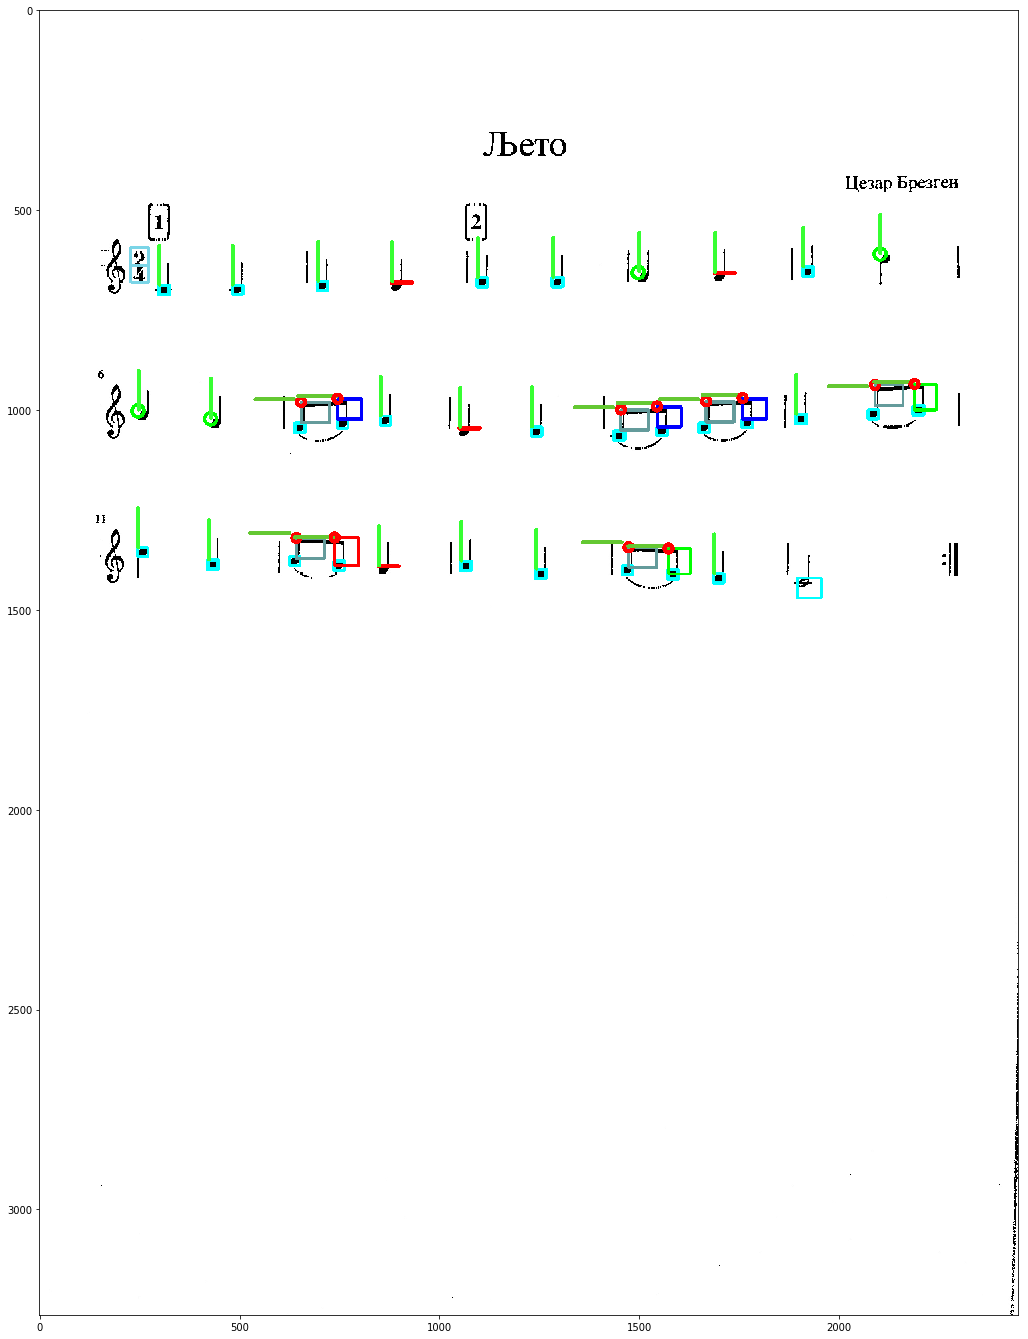

In [114]:
plt.imshow(img_no_heads_no_stems_plot)

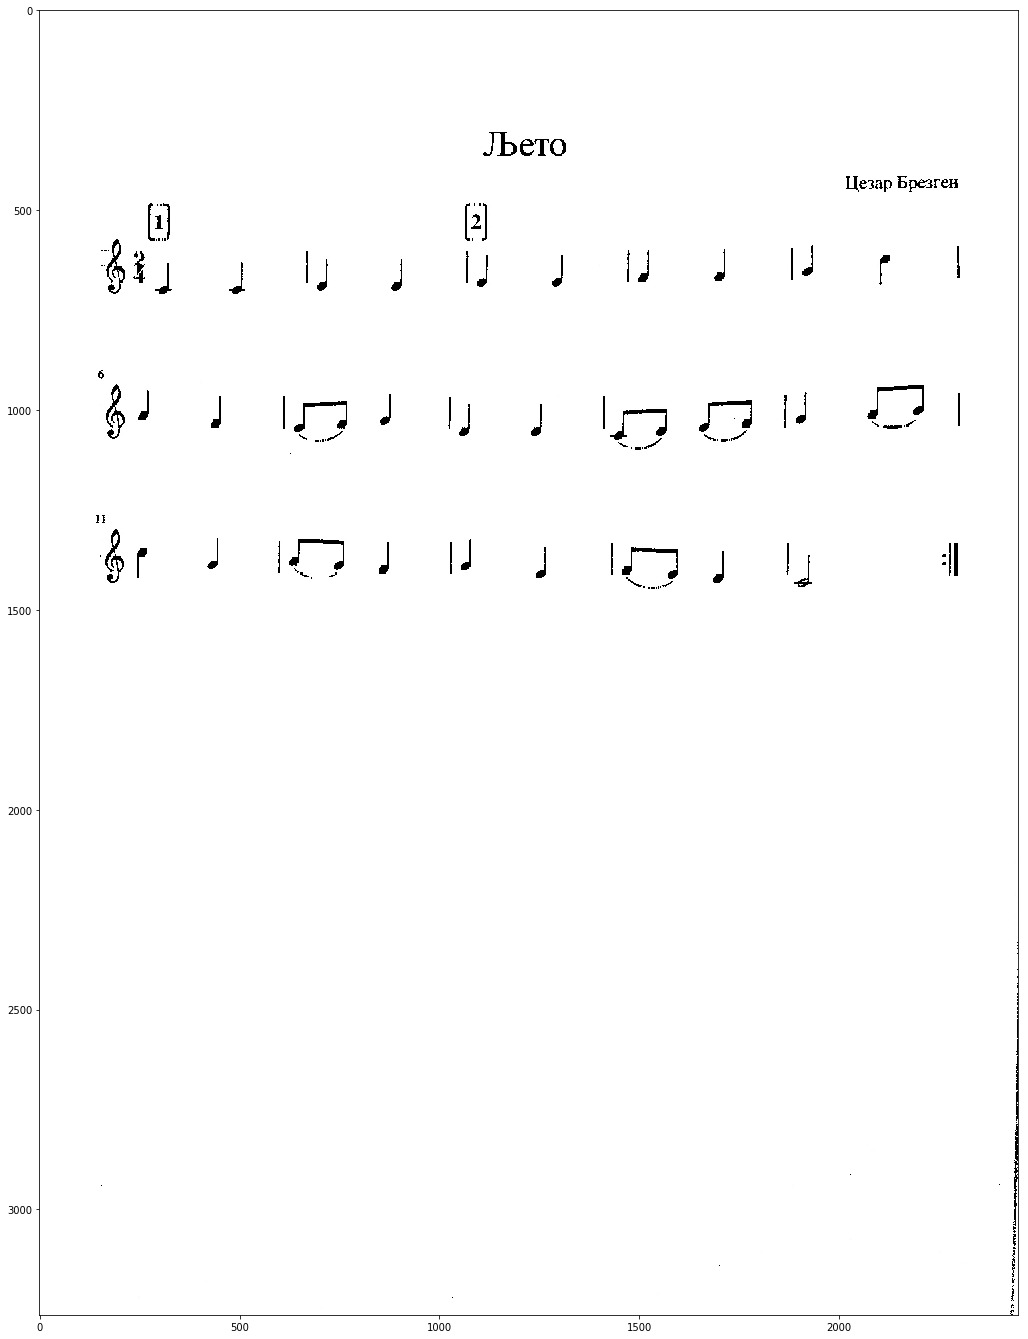

In [115]:
plt.imshow(img_accidentals_plot)

# Notes ordering

In [116]:
# trebalo bi naći način da note ubacim u konačnu listu po redoslijedu pojavljivanja u dokumentu
#- prolazim kroz sve podrjecnike glavnog rjecnika
#- za svaku tacku (key, dict[key]) odredim u kom linijskom sistemu se nalazi i izmedju kojih linija tacno
#- mozda da svaki notni sistem bude rjecnik
#- ...
for sub_dict_key, sub_dict_value in all_notes_dict.items():
    print sub_dict_key, sub_dict_value
    print

eights_up {737: 1377, 1572: 1399, 1545: 1041, 746: 1023, 2187: 988, 626: 1366, 1458: 1389, 1650: 1032, 1758: 1021, 2073: 999, 1438: 1052, 639: 1032}

eights_down {}

halves_up {1896: 1420}

halves_down {}

quarters_up {1284: 668, 246: 1344, 1095: 669, 1231: 1042, 848: 1389, 852: 1015, 1687: 1409, 1689: 656, 1242: 1398, 1051: 1043, 1054: 1378, 482: 688, 1499: 655, 1892: 1011, 423: 1374, 299: 688, 428: 1021, 881: 679, 1909: 642, 2102: 610, 247: 1001, 696: 678}

sixteens_down {}

sixteens_up {}

wholes {}

quarters_down {}



# time (beats and beat type)

In [117]:
# time
# 'two': {}, 'three': {}, 'four': {}, 'C': {}
time_x_coordinate = 0  # x coordinate where the time symbols start - used for counting key fifths before time_x coordinate
time_beats = 0  # positive integer
time_beat_type = 0  # positive integer

if single_templates_dict['C'] != {}:
    time_beats = 4
    time_beat_type = 4
    time_x_coordinate = single_templates_dict['C'].keys()[0]  # there is only one C
    
if single_templates_dict['four'] != {}:
    time_beat_type = 4  # if there is only one four, it's the beat type
    time_x_coordinate = single_templates_dict['four'].keys()[0]
    if len(single_templates_dict['four']) >= 2:  # if there are more fours, set beats to 4
        time_beats = 4
        
if single_templates_dict['three'] != {}:
    time_beats = 3  # because a 3 can only be up, as number of beats
    time_x_coordinate = single_templates_dict['three'].keys()[0]

elif single_templates_dict['two'] != {}:
    time_beats = 2  # if there is only one two, it's the beats number
    time_x_coordinate = single_templates_dict['two'].keys()[0]
    if len(single_templates_dict['two']) >= 2:  # if there are more twos, set beat type to 2 also
        time_beat_type = 2

# print single_templates_dict['two']
# print single_templates_dict['three']
# print single_templates_dict['four']
# print single_templates_dict['C']
print 'BEATS / BEAT_TYPE:', time_beats, '/', time_beat_type

BEATS / BEAT_TYPE: 2 / 4


# and key (fifths + or - some integer)

In [118]:
# key signature, tonality
key_fifths = 0
all_staves_accidentals_dict = {}
for i in range(1, number_of_staves + 1):
    all_staves_accidentals_dict[i] = {'sharps': 0, 'flats': 0}

# in single_templates_dict of sharps and flats, remain only those accidentals which are not connected with a note head
# these should, ideally, be only accidentals which are in between the Clef and time measurements
    
if len(single_templates_dict['sharps']) > 0:
    for sharp_x, sharp_y in single_templates_dict['sharps'].items():
        if sharp_x < time_x_coordinate:  # if we are checking an accidental between the Clef and time measurements
            staff_number, pitch = get_staff_and_pitch(sharp_x, sharp_y, staves_x_locations)  # staff numbers start at 1
            all_staves_accidentals_dict[staff_number]['sharps'] += 1

if len(single_templates_dict['flats']) > 0:
    for flat_x, flat_y in single_templates_dict['flats'].items():
        if flat_x < time_x_coordinate:  # if we are checking an accidental between the Clef and time measurements
            print flat_x
            staff_number, pitch = get_staff_and_pitch(flat_x, flat_y, staves_x_locations)  # staff numbers start at 1
            all_staves_accidentals_dict[staff_number]['flats'] += 1

# we determined the number of accidentals in each saff
# check which staff line contains the most unasigned accidentals (sharps or flats)
max_sharps = {'staff': 0, 'count': 0}
max_flats = {'staff': 0, 'count': 0}

for staff_number, sharps_flats_dict in all_staves_accidentals_dict.items():
    if sharps_flats_dict['sharps'] > max_sharps['count']:
        max_sharps = {'staff': staff_number, 'count': sharps_flats_dict['sharps']}
    if sharps_flats_dict['flats'] > max_sharps['count']:
        max_flats = {'staff': staff_number, 'count': sharps_flats_dict['flats']}

print max_sharps
print max_flats
if max_sharps['count'] > max_flats['count']:
    key_fifths = max_sharps['count']
    print max_sharps['staff']
else:
    key_fifths = -max_flats['count']
    print max_flats['staff']

{'count': 0, 'staff': 0}
{'count': 0, 'staff': 0}
0


In [119]:
SHARPS = ['F', 'C', 'G', 'D', 'A', 'E', 'B']
FLATS = ['B', 'E', 'A', 'D', 'G', 'C', 'F']

def get_alter_dict(key_fifths):
    accidentals_size = abs(key_fifths)
    alter_dict = {}
    if key_fifths < 0:
        alter_value = -1
        acc_list = FLATS
    else:
        alter_value = 1
        acc_list = SHARPS
    for i in range(accidentals_size):
        alter_dict[acc_list[i]] = alter_value
    return alter_dict
    

# ordering notes in staves

In [120]:
all_staves_dict = {}
for i in range(1, number_of_staves + 1):
    all_staves_dict[i] = {}

In [121]:
min_duration = 0
if all_notes_dict['sixteens_up'] == {} and all_notes_dict['sixteens_down'] == {}:
    if all_notes_dict['eights_up'] == {} and all_notes_dict['eights_down'] == {}:
        if all_notes_dict['quarters_up'] == {} and all_notes_dict['quarters_down'] == {}:
            if all_notes_dict['halves_up'] == {} and all_notes_dict['halves_down'] == {}:
                min_duration = 1
            else:
                min_duration = 2
        else:
            min_duration = 4
    else:
        min_duration = 8
else:
    min_duration = 16

# divisions = number with which we divide a quarter to get the minimum durating note element
divisions = min_duration / 4  # koliko treba najmanjih trajanja u kompoziciji da bismo dobili jednu cetvrtinu

measure_duration = min_duration / time_beat_type * time_beats

In [122]:
duration_dict = {'sixteens_up': 16, 'sixteens_down': 16, 'eights_up': 8, 'eights_down': 8, 'quarters_up': 4, 'quarters_down': 4,
                 'halves_up': 2, 'halves_down': 2, 'wholes': 1, 'eight_breaks': 8, 'quarter_breaks': 4, 'half_breaks': 2, 'whole_breaks': 1}

In [123]:
# returns the xml element type for a recognized musical element
get_xml_elem_type = {
    'sixteens_up': '16th', 'sixteens_down': '16th', 'eights_up': 'eight', 'eights_down': 'eight', 'quarters_up': 'quarter',
    'quarters_down': 'quarter', 'halves_up': 'half', 'halves_down': 'half', 'wholes': 'whole', 'eight_breaks': 'eight', 
    'quarter_breaks': 'quarter', 'half_breaks': 'half', 'whole_breaks': 'whole'
}

In [124]:
def stem_should_be_up(pitch):
    border_tone = 'B4'
    return pitch[0] > border_tone[0] and pitch[1] > border_tone[1]

def get_note_info(note_x, note_y, note_type, pitch):
    
    ret_dict_info = {} # contains all info about the note
    
    ret_dict_info['type'] = get_xml_elem_type[note_type]
    ret_dict_info['pitch'] = pitch
    
    # check for accidentals
    if all_sharps_dict.has_key(note_x):
        ret_dict_info['accidental'] = 'sharp'
    elif all_flats_dict.has_key(note_x):
        ret_dict_info['accidental'] = 'flat'
    elif all_naturals_dict.has_key(note_x):
        ret_dict_info['accidental'] = 'natural'
    
    # check stem direction, if there is one
    if note_type.find('quarter') > -1 or note_type.find('half') > -1:
        if stem_should_be_up(pitch):
            ret_dict_info['stem'] = 'up'
        else:
            ret_dict_info['stem'] = 'down'
    
    if note_type.find('up') > -1:
        ret_dict_info['stem'] = 'up'
    if note_type.find('down') > -1:
        ret_dict_info['stem'] = 'down'
    
    # if it's an eight, check for beams
    if note_type == 'eights_up':
        if all_hooks_dict['start'].has_key(note_x):
            ret_dict_info['beam'] = 'begin'
    if note_type == 'eights_down':
        if all_hooks_dict['start'].has_key(note_x):
            ret_dict_info['beam'] = 'end'
    
    # does it have it's duration lengthened by a dot
    ret_dict_info['dot'] = note_has_dot(note_x, note_y, note_type)
    
    
    # assign proper duration ;  duration_dict is as follows: 'sixteens_up': 16, 'sixteens_down': 16, 'eights_up': 8, 'eights_down': 8, 'quarters_up': 4, 'quarters_down': 4, 'halves_up': 2, 'halves_down': 2, 'wholes': 1
    ret_dict_info['duration'] = min_duration / duration_dict[note_type]
    
    return ret_dict_info

In [125]:
def get_rest_info(break_x, break_y, break_type):
    
    ret_dict_info = {} # contains all info about the note
    
    ret_dict_info['type'] = get_xml_elem_type[break_type]
    
    ret_dict_info['duration'] = min_duration / duration_dict[break_type]

In [126]:
# iterate trough all dictionaries of notes and breaks

# # for each dictionary of notes
for notes_dict_name in all_notes_dict.keys():
    for note_x, note_y in all_notes_dict[notes_dict_name].items():
        staff_number, pitch = get_staff_and_pitch(note_x, note_y, staves_x_locations)  # staff numbers start at 1
        all_staves_dict[staff_number][(note_x, note_y)] = get_note_info(note_x, note_y, notes_dict_name, pitch)
        

for breaks_dict_name in all_breaks_dict.keys():
    for break_x, break_y in all_breaks_dict[breaks_dict_name].items():
        staff_number = get_staff(break_y, staves_x_locations)[0]
        all_staves_dict[staff_number][(break_x, break_y)] = get_rest_info(break_x, break_y, breaks_dict_name)

   pitch for (x,y) = (737, 1377)  ==> A4
   staff number: 3 

   pitch for (x,y) = (1572, 1399)  ==> F4
   staff number: 3 

   pitch for (x,y) = (1545, 1041)  ==> E4
   staff number: 2 

   pitch for (x,y) = (746, 1023)  ==> G4
   staff number: 2 

   pitch for (x,y) = (2187, 988)  ==> C5
   staff number: 2 

   pitch for (x,y) = (626, 1366)  ==> B4
   staff number: 3 

   pitch for (x,y) = (1458, 1389)  ==> G4
   staff number: 3 

   pitch for (x,y) = (1650, 1032)  ==> F4
   staff number: 2 

   pitch for (x,y) = (1758, 1021)  ==> G4
   staff number: 2 

   pitch for (x,y) = (2073, 999)  ==> B4
   staff number: 2 

   pitch for (x,y) = (1438, 1052)  ==> D4
   staff number: 2 

   pitch for (x,y) = (639, 1032)  ==> F4
   staff number: 2 

   pitch for (x,y) = (1896, 1420)  ==> D4
   staff number: 3 

   pitch for (x,y) = (1284, 668)  ==> F4
   staff number: 1 

   pitch for (x,y) = (246, 1344)  ==> D5
   staff number: 3 

   pitch for (x,y) = (1095, 669)  ==> F4
   staff number: 1 

 

# ended notes ordering and moving staves

# Generate MusicXML

In [176]:
filename = get_image_name() # 'bolujem' is default
f = open(RESULTS_PATH + '/' + filename + '.xml', 'w')
xml_string = ''

In [177]:
# sort all symbols in each stave
#for stave_symbols_dict in all_staves_dict.values():
    #print stave_symbols_dict

In [178]:
# write initial data
xml_string += '''<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE score-partwise PUBLIC "-//Recordare//DTD MusicXML 3.0 Partwise//EN" "http://www.musicxml.org/dtds/partwise.dtd">
<score-partwise>
  <identification>
    <encoding>
      <software>MuseScore 2.1.0</software>
      <encoding-date>2018-02-18</encoding-date>
      <supports element="accidental" type="yes"/>
      <supports element="beam" type="yes"/>
      <supports element="print" attribute="new-page" type="yes" value="yes"/>
      <supports element="print" attribute="new-system" type="yes" value="yes"/>
      <supports element="stem" type="yes"/>
      </encoding>
    </identification>
  <defaults>
    <scaling>
      <millimeters>7.056</millimeters>
      <tenths>40</tenths>
      </scaling>
    <page-layout>
      <page-height>1683.67</page-height>
      <page-width>1190.48</page-width>
      <page-margins type="even">
        <left-margin>56.6893</left-margin>
        <right-margin>56.6893</right-margin>
        <top-margin>56.6893</top-margin>
        <bottom-margin>113.379</bottom-margin>
        </page-margins>
      <page-margins type="odd">
        <left-margin>56.6893</left-margin>
        <right-margin>56.6893</right-margin>
        <top-margin>56.6893</top-margin>
        <bottom-margin>113.379</bottom-margin>
        </page-margins>
      </page-layout>
    <word-font font-family="FreeSerif" font-size="10"/>
    <lyric-font font-family="FreeSerif" font-size="11"/>
    </defaults>
  <credit page="1">
    <credit-words default-x="595.238" default-y="1626.98" justify="center" valign="top" font-size="24">''' + filename + '''
    </credit-words>
    </credit>
  <credit page="1">
    <credit-words default-x="1167.31" default-y="1427.31" justify="right" valign="bottom" font-size="12">Цезар Брезген</credit-words>
    </credit>
  <part-list>
    <score-part id="P1">
      <part-name>Voice</part-name>
      <part-abbreviation>Vo.</part-abbreviation>
      <score-instrument id="P1-I1">
        <instrument-name>Voice</instrument-name>
        </score-instrument>
      <midi-device id="P1-I1" port="1"></midi-device>
      <midi-instrument id="P1-I1">
        <midi-channel>1</midi-channel>
        <midi-program>53</midi-program>
        <volume>78.7402</volume>
        <pan>0</pan>
        </midi-instrument>
      </score-part>
    </part-list>
  <part id="P1">'''

first_measure_str = '''<print>
        <system-layout>
          <system-margins>
            <left-margin>-0.00</left-margin>
            <right-margin>-0.00</right-margin>
            </system-margins>
          <top-system-distance>170.00</top-system-distance>
          </system-layout>
        </print>
      <attributes>
      <divisions>''' + str(divisions) + '''</divisions>
        <key>
          <fifths>''' + str(key_fifths) + '''</fifths>
          </key>
        <time>
          <beats>''' + str(time_beats) + '''</beats>
          <beat-type>''' + str(time_beat_type) + '''</beat-type>
          </time>
        <clef>
          <sign>G</sign>
          <line>2</line>
          </clef>
        </attributes>'''

In [179]:
# sort all symbols in each stave
all_staves_dict_copy = all_staves_dict.copy()
measure_number = 1  # next measure number is 2 because we already added measure number 1 in the starting XML

# dictionary of pitches that will be altered {'F': 1, 'C': 1}
alter_dict = get_alter_dict(key_fifths)

measure_ended = False
for stave_symbols_dict in all_staves_dict_copy.values():
    if (measure_number == 1):
        xml_string += '''<measure number="'''+ str(measure_number) +'''" width="211.90">'''
        xml_string += first_measure_str
    stave_keys = stave_symbols_dict.keys()
    stave_keys.sort()  # sort symbols by x coordinate
    print stave_keys
    # we have sorted all elements in the current stave
    # now... WE SHALL PROCEED WITH THE GENERATING PROCESS!!!
    # create measure with notes
    measure_duration_sum = 0  # create new one when this number exceeds
    beam_counter = 1
    for music_symbol_key in stave_keys:
        if (measure_ended):
            measure_ended = False
            xml_string += '''<measure number="'''+ str(measure_number) +'''" width="211.90">'''
        
        music_symbol_val = stave_symbols_dict[music_symbol_key]
        xml_string += '''<note default-x="102.27" default-y="-25.00">'''
        if music_symbol_val.has_key('pitch'):
            note_name = music_symbol_val['pitch'][0]
            alter_value = alter_dict.get(note_name)
            xml_string += '''<pitch>''' + '''<step>''' + note_name + '''</step>'''
            if (alter_value is not None):
                xml_string += '''<alter>''' + str(alter_value) + '''</alter>'''
            xml_string += '''<octave>''' + music_symbol_val['pitch'][1] + '''</octave></pitch>'''
        else:
            xml_string += '''<rest/>'''
        
        xml_string += '''<duration>''' + str(music_symbol_val['duration']) + '''</duration><voice>1</voice>
        <type>''' + music_symbol_val['type'] + '''</type>'''
        if music_symbol_val.has_key('pitch'):
            if music_symbol_val.has_key('accidental'):
                xml_string += '''<accidental>''' + music_symbol_val['accidental'] + '''</accidental>'''
            xml_string += '''<stem>''' + music_symbol_val['stem'] + '''</stem>'''
        if music_symbol_val.has_key('beam'):
            xml_string += '''<beam number="''' + str(beam_counter) + '''">''' + music_symbol_val['stem'] + '''</beam>'''
            beam_counter += 1
        
        xml_string += '''</note>'''
        
        measure_duration_sum += music_symbol_val['duration']
        # check if we should end this measure
        if measure_duration_sum == measure_duration:
            beam_counter = 1
            measure_number += 1
            measure_duration_sum = 0
            measure_ended = True
            xml_string += '''</measure>'''
# if we didn't count the durations well, measure is not ended
# if not(measure_ended):
#     xml_string += '''</measure>'''
xml_string += '''</part></score-partwise>'''

[(299, 688), (482, 688), (696, 678), (881, 679), (1095, 669), (1284, 668), (1499, 655), (1689, 656), (1909, 642), (2102, 610)]
[(247, 1001), (428, 1021), (639, 1032), (746, 1023), (852, 1015), (1051, 1043), (1231, 1042), (1438, 1052), (1545, 1041), (1650, 1032), (1758, 1021), (1892, 1011), (2073, 999), (2187, 988)]
[(246, 1344), (423, 1374), (626, 1366), (737, 1377), (848, 1389), (1054, 1378), (1242, 1398), (1458, 1389), (1572, 1399), (1687, 1409), (1896, 1420)]


# Write XML to file

In [180]:
f.writelines(xml_string)
f.flush()
f.close()

In [181]:
a = {2:3, 5:7}
print a.get(2) is not None

True
